In [101]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 200
import matplotlib.colors as colors
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import numpy.linalg as la
import os
import seaborn as sns
from sklearn.metrics import r2_score, roc_auc_score
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import StepLR
from pathlib import Path
from scipy.stats import norm
import statistics

### **Low Rank Model Code**

In [102]:
#Fills in NaN values in y_session

path = r"C:\Users\andre\Desktop\active_neuron\data\sample_photostim_59_spatial_date_070623.npy"
data = np.load(path, allow_pickle = True).item() #dict

for key in data.keys():
    print(key)

print(data['o1'].shape) #(10,100)

y_session = data['y_session']  #np.ndarray photostimulation intensity value (t, neurons)
u_session = data['u_session']  #np.ndarray t:t+3 is 1 for stimulated (t, neurons)

y_session_interp = y_session.copy()
for i in range(y_session.shape[1]):  #i loop over neurons
    nan_start = -1
    nan_stop = -1
    for j in range(y_session.shape[0]):  #j loop over t
        if nan_start == -1 and np.isnan(y_session_interp[j,i]):  #if no nan detected yet and 1 is detected
            nan_start = j - 1  # set nan_start to 1 t before detected index
        if nan_start != -1 and not np.isnan(y_session_interp[j,i]):  # if nan has been detected previously and no longer detected
            nan_stop = j  #set nan_stop to t
        if nan_start != -1 and nan_stop != -1: #if a valid nan interval has been detected
            slope = y_session_interp[nan_stop,i] - y_session_interp[nan_start,i]
            for k in range(nan_stop - nan_start - 1):  #linearly interpolate the detected nan interval, in the y_session data
                y_session_interp[nan_start + k + 1,i] = slope*k/(nan_stop-nan_start-1) + y_session_interp[nan_start,i]
            nan_start = -1
            nan_stop = -1


u_session
u_spatial_session
y_session
x1
x2
o1
o2
(10, 100)


(502,) idx is a np.array of size n with the actual n's as the values
(502,) on is a np.array boolean mask of size n with trues and falses of if that neuron is above 0 or not (stimulated or not)
[  2  17  21  60  67  75 105 129 149 196 273] pattern is now the neurons at t which were non-zero
added this pattern: [  2  17  21  60  67  75 105 129 149 196 273]
pattern count is now [1]
added pattern index [[1]]
pattern length is now [11]
 
(502,) idx is a np.array of size n with the actual n's as the values
(502,) on is a np.array boolean mask of size n with trues and falses of if that neuron is above 0 or not (stimulated or not)
[  4  75  95  98 108 164 170 173 226 257 279 319 367] pattern is now the neurons at t which were non-zero
added this pattern: [  4  75  95  98 108 164 170 173 226 257 279 319 367]
pattern count is now [1, 1]
added pattern index [[1], [15]]
pattern length is now [11, 13]
 
(502,) idx is a np.array of size n with the actual n's as the values
(502,) on is a np.array bo

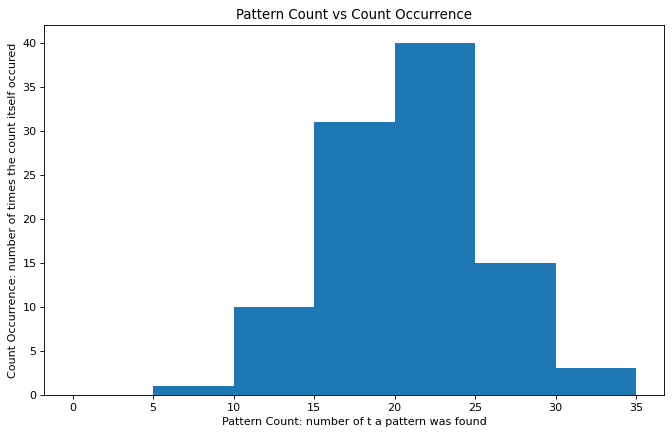

In [103]:
#Pattern counting, a pattern is the non-zero/stimulated neurons

patterns = []
pattern_count = []
pattern_idx = []
pattern_length = []

start = -10
for t in range(u_session.shape[0]):  #loop through t

    #if there is a single non_zero element in t-th row of u_session 
    #and if t is more than 4 units greater than start
    if np.sum(np.abs(u_session[t,:])) > 0 and t > start + 4:

        idx = np.linspace(0,u_session.shape[1]-1,u_session.shape[1]).astype(int)
        print(f"{idx.shape} idx is a np.array of size n with the actual n's as the values")

        on = u_session[t,:] > 0
        print(f"{on.shape} on is a np.array boolean mask of size n with trues and falses of if that neuron is above 0 or not (stimulated or not)")

        pattern = np.array(idx[on])
        print(f"{pattern} pattern is now the neurons at t which were non-zero")

        start = t  #set start to the current trial we are on
        found = False
        for i in range(len(patterns)):

            # if pattern has been found already
            if len(pattern) == len(patterns[i]):
                if np.linalg.norm(pattern - patterns[i]) == 0:
                    pattern_count[i] += 1
                    pattern_idx[i].append(t)
                    found = True
                    break

        # if pattern has not been found yet
        if found is False:
            patterns.append(pattern)  #there are 100 patterns
            pattern_count.append(1)
            pattern_idx.append([t])  #append the trial as the pattern_idx
            pattern_length.append(len(pattern))

            print(f"added this pattern: {pattern}")
            print(f"pattern count is now {pattern_count}")
            print(f"added pattern index {pattern_idx}")
            print(f"pattern length is now {pattern_length}")
            print(" ")

print(f"patterns should be {len(patterns)} long")
print(f"pattern_count is the number of times each pattern was found.{pattern_count}")
print(f"pattern_idx is all the t's that each pattern was found at, so this is going to be 100 sub arrays of a bunch of t's {pattern_idx}")
print(f"pattern_length is the lengths of all patterns found. {pattern_length}")

#counting how many patterns each neuron is involved in, store in neuron_pattern
neuron_pattern = np.zeros(u_session.shape[1])
for i in range(u_session.shape[1]):
    for p in patterns:
        if i in p:
            neuron_pattern[i] += 1

plt.figure(figsize=(10, 6), dpi=80)
plt.hist(pattern_count, bins=[0,5,10,15,20,25,30,35])
plt.title("Pattern Count vs Count Occurrence")
plt.xlabel('Pattern Count: number of t a pattern was found')
plt.ylabel('Count Occurrence: number of times the count itself occured')
plt.show()

#(20, 10) means there are 10 unique patterns 
#that occurred exactly 20 times across all trials

In [104]:
idx = np.linspace(0,u_session.shape[1]-1,u_session.shape[1]).astype(int)
print(f"{idx.shape} idx is a np.array of size n with the actual n's as the values")

# This will be 502 trues and falses
on = u_session[1,:] > 0
print(f"{on.shape} on is a np.array of size n with trues and falses of if that neuron is above 0 or not")

print(idx[on])
print(f"{pattern} pattern is now the neurons at t which were non-zero")

(502,) idx is a np.array of size n with the actual n's as the values
(502,) on is a np.array of size n with trues and falses of if that neuron is above 0 or not
[  2  17  21  60  67  75 105 129 149 196 273]
[ 80 110 111 139 144 177 196 216 219 321 469 485] pattern is now the neurons at t which were non-zero


### Train-Test Split ###

- remove 5 patterns each which looks like [63, 65, 95, 98, 124, 265, 279, 312, 367, 386, 399, 403, 484, 486, 489].

- loop through every t that each pattern happens at which looks like [1, 1331, 3293, 3423, 6683, 7027, 10538, 14364, 16006, 19633, 20631, 21900, 23637, 24467, 24966, 25853, 26282, 26354, 27601]
and remove 20 t steps before it and 50 t steps after it

pattern id: 44
removed pattern indexes are now [44]
total removed pattern count is now 17
total removed neurons are now [63, 65, 95, 98, 124, 265, 279, 312, 367, 386, 399, 403, 484, 486, 489]
pattern id: 47
removed pattern indexes are now [44, 47]
total removed pattern count is now 37
total removed neurons are now [63, 65, 95, 98, 124, 265, 279, 312, 367, 386, 399, 403, 484, 486, 489, 1, 33, 49, 67, 95, 129, 196, 265, 279, 342, 367, 419]
pattern id: 64
removed pattern indexes are now [44, 47, 64]
total removed pattern count is now 57
total removed neurons are now [63, 65, 95, 98, 124, 265, 279, 312, 367, 386, 399, 403, 484, 486, 489, 1, 33, 49, 67, 95, 129, 196, 265, 279, 342, 367, 419, 76, 194, 223, 230, 236, 242, 293, 322, 359, 385, 461]
pattern id: 67
removed pattern indexes are now [44, 47, 64, 67]
total removed pattern count is now 76
total removed neurons are now [63, 65, 95, 98, 124, 265, 279, 312, 367, 386, 399, 403, 484, 486, 489, 1, 33, 49, 67, 95, 129, 196, 265, 279, 342, 36

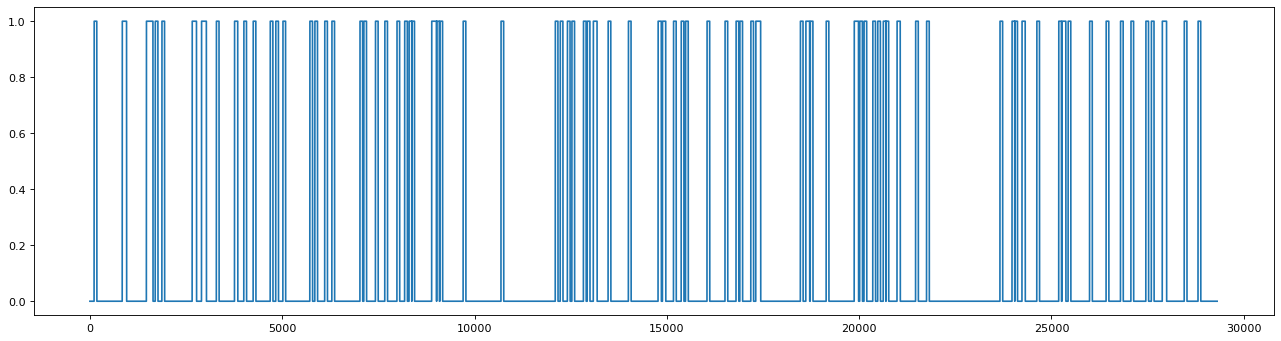

EX of pattern_idx[p_idx] will be a series of t's where this pattern occurred [861, 1546, 3780, 4022, 5738, 8906, 9724, 12950, 14792, 14921, 20374, 20717, 21018, 24253, 24267, 25452, 26010]
117 t's and intervals of t-20:t+50 for each one of these was marked for test set ~roughly, some at end left out
train set is 22968 1's in a np.array 29308 long.
test set is 6340 1's in a np.array 29308 long.


In [105]:
# remove patterns randomly
# ??? Why only 5 patterns?
num_patterns = 5
removed_patterns = []
removed_neurons = []
removed_steps = np.zeros(u_session.shape[0])
removed_count = 0

np.random.seed(0)
while len(removed_patterns) < num_patterns:  # while the patterns are NOT all removed
    p_idx = np.random.randint(0,len(patterns))  #pick random pattern index, 1-100
    print('pattern id:', p_idx)
    if p_idx not in removed_patterns:
        removed_patterns.append(p_idx)
        removed_count += pattern_count[p_idx]  # += will be a number like 22
        print(f"removed pattern indexes are now {removed_patterns}")
        print(f"total removed pattern count is now {removed_count}")
        
        #add each [1,99,500, etc.] pattern of neurons at p_idx to removed_neurons
        removed_neurons.extend(patterns[p_idx])
        print(f"total removed neurons are now {removed_neurons}")

        #looping through the t's the pattern at p_idx occurred at
        #remove interval from 20 before t to 50 after t
        for i in pattern_idx[p_idx]:  
            min_idx = np.max([0,i-20])
            max_idx = np.min([i+50,u_session.shape[0]-1])
            #marked all t's in this interval for removal with a 1
            removed_steps[min_idx:max_idx] = 1

print(f"print the number of removed t's {np.sum(removed_steps)}")
print(f"print total removed pattern count {removed_count} and print the fraction of removed t's {np.sum(removed_steps) / u_session.shape[0]}")
print(f"print the removed pattern indexes {removed_patterns}")
plt.figure(figsize=(20,5), dpi=80)
plt.plot(removed_steps)
plt.show()

#set the removed steps as the test set
test_indices = removed_steps.astype(int)

#set the non removed steps as the train set
train_indices = np.ones(test_indices.shape[0]).astype(int) - test_indices.copy()
removed_neurons = list(set(removed_neurons))

print(f"EX of pattern_idx[p_idx] will be a series of t's where this pattern occurred {pattern_idx[44]}")
print(f"{len(pattern_idx[44] + pattern_idx[44] + pattern_idx[47] + pattern_idx[64] + pattern_idx[67] + pattern_idx[9])} t's and intervals of t-20:t+50 for each one of these was marked for test set ~roughly, some at end left out")

print(f"train set is {np.sum(train_indices)} 1's in a np.array {len(train_indices)} long.")
print(f"test set is {np.sum(test_indices)} 1's in a np.array {len(test_indices)} long.")

train_test_split = {}
train_test_split['train_indices'] = train_indices
train_test_split['test_indices'] = test_indices
# np.save('train_test_split',train_test_split)

### Plot the True Spikes ###

for neuron

In [106]:
spiking = np.zeros(u_session.shape).astype(bool)
print(f"{spiking.shape} spiking is boolean matrix of shape u_session.shape")

for neuron in range(u_session.shape[1]):
    output_true = y_session_interp[4:,neuron]
    #baseline intensity level for neuron
    mean_threshold = np.median(output_true)

    #idxs of t's where activity is lower than baseline
    lower_tail_idx = (output_true < mean_threshold)

    lower_tail_data = output_true[lower_tail_idx]

    lower_tail_std = np.std(lower_tail_data)

    true_spike_threshold = mean_threshold + 6*lower_tail_std #identify spikes
    true_spikes = (output_true > true_spike_threshold)
    spiking[4:,neuron] = true_spikes  

print(f"{mean_threshold} is the median intensity value for neuron {neuron}")
print(f"{lower_tail_std} is the lower tail std dev for neuron {neuron}'s intensity values")
print(f"{np.sum(lower_tail_idx)} / {len(lower_tail_idx)} is the proportion of lower tail for neuron {neuron}")
print(f"{lower_tail_data} these are the actual intensity values of the lower tail for neuron {neuron}")

print(f"{true_spikes} true_spikes is a boolean array of if an intensity reading at t is considered a spike or not")
print(f"{np.sum(true_spikes)} / {len(true_spikes)} are considered true spikes for neuron {neuron}")
#np.save('spiking_labels',spiking)

(29308, 502) spiking is boolean matrix of shape u_session.shape
22.972501754760742 is the median intensity value for neuron 501
4.487064838409424 is the lower tail std dev for neuron 501's intensity values
14652 / 29304 is the proportion of lower tail for neuron 501
[ 8.178019  4.365546 14.016649 ... 22.799147 19.464046 19.380882] these are the actual intensity values of the lower tail for neuron 501
[False False False ... False False False] true_spikes is a boolean array of if an intensity reading at t is considered a spike or not
505 / 29304 are considered true spikes for neuron 501


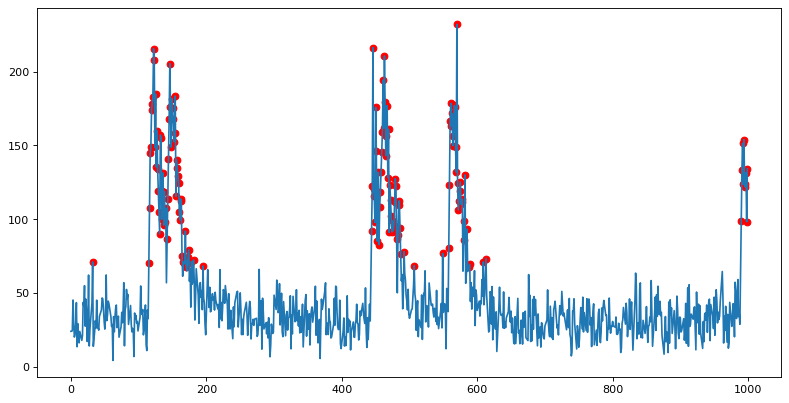

In [107]:
neuron = 206
T = 1000
plt.figure(figsize=(12,6), dpi=80)
plt.plot(y_session_interp[:T,neuron])
idx = np.linspace(0,T-1,T)
spiking_neuron = spiking[:T,neuron]  # (1000, 1) boolean spike or not for 1st 1000 t
y_out = y_session_interp[:T,neuron].copy()  # (1000, 1) actual intensity values for 1st 1000 t

y_out = y_out * spiking_neuron  # 0 out non-spikes
y_out[y_out == 0] = np.nan  # nan out the non-spikes
plt.scatter(idx,y_out,color='r')  
plt.show()

### **Train Model** ###

first block, recreate/filter the indices to make sure the k intervals are respected.

In [108]:
def to_np(tens):
    return tens.detach().cpu().numpy()

# NOTE: This function is recreating/filtering train_indices and val_indices, it only adds i from input, IF i and num_lags i's after are ALL 1 (train) or ALL 0 (val) respectively
def filter_indices_with_lags(train_data_index, num_lags):
    train_indices = []
    val_indices = []
    # train_data_index = train_indices[train_start:]
    # NOTE: minus num_lags so our indexing doesn't break at the end
    # looping through train_indices[5:29304], 5=train_start from start, 4=num_lags from last
    for i in range(len(train_data_index) - num_lags):

        # if current i and the num_lags next i's are ALL 1, add to train_indices
        if all(train_data_index[i + j] == 1 for j in range(num_lags + 1)):
            train_indices.append(i)
        # else if current i and the num_lags next i's are ALL 0, add to val_indices
        elif all(train_data_index[i + j] == 0 for j in range(num_lags + 1)):
            val_indices.append(i)
    
    return train_indices, val_indices

def split_dataset(dataset, train_data_index, num_lags):
    train_indices, val_indices = filter_indices_with_lags(train_data_index, num_lags)
    
    # Create subsets for training and validation
    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)
    return train_subset, val_subset

In [109]:
class TimeseriesDataset(Dataset):

    # X is basically torch.tensor(y_session), U is basically torch.tensor(u_session)
    def __init__(self, X, U, num_lags):
        self.X = X
        self.U = U 
        self.num_lags = num_lags

    def __len__(self):
        # The dataset length is reduced by num_lags due to the dependency on previous data points
        return len(self.X) - self.num_lags

# NOTE: This function is returning 4 index history of X and U as well as the prediction point X
    def __getitem__(self, index):
        # return slices of X and U of [index:index + num_lags]
        X_history = [self.X[index + i] for i in range(self.num_lags)]
        U_history = [self.U[index + i] for i in range(self.num_lags)]

        # X_next is the prediction point
        X_next = self.X[index + self.num_lags]
        return X_history, U_history, X_next

# NOTE: This function normalizes matrix such that the largest singular value becomes 2
def singular_value_norm(matrix):
    norm_val = torch.linalg.norm(matrix, 2)  # norm_val = largest singular value of matrix
    if norm_val > 2: 
        matrix = 2 * matrix / norm_val  # normalized/scaled such that the largest singular values becomes 2
    return matrix


class LinearDynamicModel(nn.Module):  # inherit from nn.Module which is base class for all neural network in pytorch
    def __init__(self, state_dim, input_dim, num_lags, init_value = None):
        
        super(LinearDynamicModel, self).__init__()  # constructor of nn.Module, gives functionalities of nn.Module to LinearDynamicModel
        
        # if doesn't exist yet, create a new parameter list
        if init_value is None:
            # Create diagonal matrices for alpha and beta, one for each lag

            # nn.ParameterList is like Python list, but tensors that are nn.Parameter are visible by all Module methods and autograd will work
            # torch.randn(state_dim) creates tensor of len(state_dim) of random numbers from normal distribution (0, 1)
            # alpha and beta are lists of parameters with num_lags=4 tensors of size state_dim=502
            self.alpha = nn.ParameterList([nn.Parameter(torch.randn(state_dim)) for _ in range(num_lags)])
            self.beta = nn.ParameterList([nn.Parameter(torch.randn(state_dim)) for _ in range(num_lags)])
            
            # W is matrix A and B is matrix B in the paper
            # W and B are lists of parameters with num_lags=4 tensors of size (state_dim, state_dim) and (state_dim, input_dim)
            self.W = nn.ParameterList([nn.Parameter(torch.randn(state_dim, state_dim)) for _ in range(num_lags)])
            self.B = nn.ParameterList([nn.Parameter(torch.randn(state_dim, input_dim)) for _ in range(num_lags)]) # this is full-rank, linear model so i think state_dim=input_dim

            # V is a parameter tensor of size state_dim
            self.V = nn.Parameter(torch.randn(state_dim))

        # if already exists, create the parameter list by pulling from the existing dictionary init_value
        else:
            # init_value is a {} dictionary of [] lists
            self.alpha = nn.ParameterList([nn.Parameter(init_value['alpha'][i]) for i in range(num_lags)])
            self.beta = nn.ParameterList([nn.Parameter(init_value['beta'][i]) for i in range(num_lags)])

            self.W = nn.ParameterList([nn.Parameter(init_value['W'][i]) for i in range(num_lags)])
            self.B = nn.ParameterList([nn.Parameter(init_value['B'][i]) for _ in range(num_lags)])

            self.V = nn.Parameter(init_value['V'])
    

    def forward(self, X_history, U_history):
        # initialize tensor of 0s of same size as first X_history tensor so we would expect X_next to be size (502)
        X_next = torch.zeros_like(X_history[0])

        #  self.W is ParameterList of 4 tensors of size (502, 502)
        #  self.alpha is ParameterList of 4 tensors of size (502)
        #  X_history is python list of size (4, 502)
        for W_k, alpha_k, X_k in zip(self.W, self.alpha, X_history):
            # W_k (502, 502)
            # alpha_k (502)
            # X_k (502)

            X_k = X_k.unsqueeze(-1)
            alpha_diag_k = torch.diag(alpha_k)

            # unsqueeze X_k so it now has shape (502, 1), add extra dimension
            # torch.diag(alpha_k) so alpha_diag_k has shape (502, 502)

            # compute contribution of state X_k to state X_next
            # matrices A and B correspond to W + diag(alpha) and B + diag(beta)
            # (502, 502) @ (502, 1) = (502,1).squeeze(-1) = (502)
            contribution = torch.matmul(singular_value_norm(W_k + alpha_diag_k), X_k).squeeze(-1)

            # X_next is (502) of 0's so add contribution to it
            # X_next now has the contribution of num_lags previous states
            X_next += contribution

        #  self.B is ParameterList of 4 tensors of size (502, input_dim)
        #  self.beta is ParameterList of 4 tensors of size (502)
        #  U_history is python list of size (4, 502)
        for B_k, beta_k, U_k in zip(self.B, self.beta, U_history):
            U_k = U_k.unsqueeze(-1)
            beta_diag_k = torch.diag(beta_k)
            # B_k (502, input_dim=502), full rank model so state_dim = input_dim
            # U_k (502, 1)
            # beta_diag_k (502, 502)

            # compute contribution of input U_k to next state X-next
            # (502,502) @ (502,1) = (502,1).squeeze(-1) = (502)
            contribution = torch.matmul(singular_value_norm(B_k + beta_diag_k), U_k).squeeze(-1)

            # X_next now has contribution of num_lags previous states AND num_lags previous inputs
            # X_next is still (502)
            X_next += contribution

        # X_next is still (502)
        X_next += self.V[None, :]
        return X_next
    
class LowRankLinearDynamicModel(nn.Module):  # inherit from nn.Module which is base class for all neural network in pytorch
    def __init__(self, state_dim, input_dim, rank_dim, num_lags, init_value = None):
        super(LowRankLinearDynamicModel, self).__init__()  # constructor of nn.Module, gives functionalities of nn.Module to LinearDynamicModel
        
        if init_value is None:
            # self.alpha and self.beta are both ParameterList of 4 Parameters each a tensor of size (502)
            self.alpha = nn.ParameterList([nn.Parameter(torch.randn(state_dim)) for _ in range(num_lags)])
            self.beta = nn.ParameterList([nn.Parameter(torch.randn(state_dim)) for _ in range(num_lags)])

            # self.W_u and self.W_v are both ParameterList of 4 Parameters each a tensor of size (502, 5)
            self.W_u = nn.ParameterList([nn.Parameter(torch.randn(state_dim, rank_dim)) for _ in range(num_lags)])
            self.W_v = nn.ParameterList([nn.Parameter(torch.randn(state_dim, rank_dim)) for _ in range(num_lags)])

            # self.B_u and self.B_v are both ParameterList of 4 Parameters each a tensor of size (502, 5)
            self.B_u = nn.ParameterList([nn.Parameter(torch.randn(state_dim, rank_dim)) for _ in range(num_lags)])
            self.B_v = nn.ParameterList([nn.Parameter(torch.randn(state_dim, rank_dim)) for _ in range(num_lags)])

            # self.V is a Parameter tensor of size (502)
            self.V = nn.Parameter(torch.randn(state_dim))
        else:
            self.alpha = nn.ParameterList([nn.Parameter(init_value['alpha'][i]) for i in range(num_lags)])
            self.beta = nn.ParameterList([nn.Parameter(init_value['beta'][i]) for i in range(num_lags)])

            self.W_u = nn.ParameterList([nn.Parameter(init_value['W_u'][i]) for i in range(num_lags)])
            self.W_v = nn.ParameterList([nn.Parameter(init_value['W_v'][i]) for i in range(num_lags)])

            self.B_u = nn.ParameterList([nn.Parameter(init_value['B_u'][i]) for _ in range(num_lags)])
            self.B_v = nn.ParameterList([nn.Parameter(init_value['B_v'][i]) for _ in range(num_lags)])

            self.V = nn.Parameter(init_value['V'])
        
    def forward(self, X_history, U_history):
        X_next = torch.zeros_like(X_history[0])  # (502)
        for W_u_k, W_v_k, alpha_k, X_k in zip(self.W_u, self.W_v, self.alpha, X_history):
            X_k = X_k.unsqueeze(-1)  
            alpha_diag_k = torch.diag(alpha_k)
            # W_u_k and W_v_k(502, 35) low rank approx. of matrix A
            # alpha_diag_k (502, 502) original diagonals of each of the 4 (502,502) in Ahat ~ y_session[t:t+4]
            # X_k (502, 1) each of the 4 previous states

            # U_A @ V_A.T (502, 502)
            W_k = torch.mm(W_u_k, W_v_k.T)  # reconstruct each of 4 A matrix 
            
            # A_s = U_A @ V_A.T + D_A
            # (502, 502) @ (502, 1) = (502, 1).squeeze(-1) = (502)
            contribution = torch.matmul(singular_value_norm(W_k + alpha_diag_k), X_k).squeeze(-1)  # Shape returns to (batch_size, state_dim)
            X_next += contribution  # add each of the 4 contributions from the previous states to x_next (502,)

        for B_u_k, B_v_k, beta_k, U_k in zip(self.B_u, self.B_v, self.beta, U_history):
            U_k = U_k.unsqueeze(-1)
            beta_diag_k = torch.diag(beta_k)
            # B_u_k and B_v_k (502, 35) low rank approx. of matrix B
            # beta_diag_k (502, 502) (502, 502) original diagonals of each of the 4 (502,502) in Ahat ~ u_session[t:t+4]
            # U_k (502, 1) each of the 4 previous inputs

            # U_B @ V_B.T (502, 502)
            B_k = torch.mm(B_u_k, B_v_k.T)  # reconstruct each of 4 B matrix 
            
            # B_s = U_B @ V_B.T + D_B
            # (502, 502) @ (502, 1) = (502, 1).squeeze(-1) = (502)
            contribution = torch.matmul(singular_value_norm(B_k + beta_diag_k), U_k).squeeze(-1)
            X_next += contribution  # add each of the 4 contributions from the previous inputs to x_next (502,)

        # X_next is (502,) of all contributions from each of the previous 4 states and inputs    
        X_next += self.V[None, :]  # account for bias term
        return X_next

def train_model(model, train_loader, val_loader, epochs=100, lr=0.01, clip_value=1.0, l2_lambda=0.01, step_size=50, gamma=0.5, checkpoint_name = 'linear_35'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # Decays the lr of each parameter by a factor of gamma at every step_size
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    criterion = nn.MSELoss()
    best_val_loss = float('inf')
    
    # Lists to track loss
    train_losses = []
    val_losses = []
    l2_penalty_losses = []
    
    current_lr = lr

    for epoch in range(epochs):
        # Training Phase
        model.train()  # set model to training mode
        total_train_loss = 0
        total_l2_penaty = 0

        for X_history, U_history, X_next in train_loader:  # loop through 12 train batches in train_loader
            optimizer.zero_grad()  # zero out gradients for each batch
            predictions = model(X_history, U_history)  # this is X_next (502) from forward method
            loss = criterion(predictions, X_next)  # take loss betwen X_next (502) predicted and X_next true
            # print(f"pre_L2_loss: {loss}")
            
            # total_train_loss += loss.item()
            
            # Compute the L2 penalty for each parameter
            l2_penalty = torch.tensor(0.).to(device)
            
            for param in model.W_u:
                l2_penalty += torch.norm(param,p=2)
            # print(f"l2_penalty is {l2_penalty}")
            for param in model.W_v:
                l2_penalty += torch.norm(param,p=2)
            for param in model.B_u:
                l2_penalty += torch.norm(param,p=2)
            for param in model.B_v:
                l2_penalty += torch.norm(param,p=2)
            for param in model.alpha:
                l2_penalty += torch.norm(param,p=2)
            for param in model.beta:
                l2_penalty += torch.norm(param,p=2)
            
            # Add the L2 penalty to the original loss
            loss += l2_lambda * l2_penalty
            
            total_train_loss += loss.item()  # ??? Maybe this is why its higher than val loss.

            # print(f"post_L2_loss: {loss}")

            total_l2_penaty += l2_penalty.item()

            # accumulates dloss/dx for every parameter x into x.grad for every parameter x
            # x.grad += dloss/dx
            loss.backward()

            # x += -lr * x.grad, update parameters with gradients
            optimizer.step()
        

        # Validation Phase
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for X_history, U_history, X_next in val_loader:  # loop through 4 val batches of 2000 in val_loader
                predictions = model(X_history, U_history)
                loss = criterion(predictions, X_next)
                total_val_loss += loss.item()

        # Logging average training and validation loss, and L2 penalty
        # TODO: need some clarity if this is computing the loss from 1 sample from the batch of 2000 or somehow doing it for all points, i think the gap is in how __getitem__ works
        train_loss = total_train_loss / len(train_loader)
        val_loss = total_val_loss / len(val_loader)
        l2_penaty_loss = total_l2_penaty / len(train_loader)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        l2_penalty_losses.append(l2_penaty_loss)
        
        print(f'Epoch {epoch}: Train Loss = {train_loss}, Val Loss = {val_loss}, L2 Penalty Loss = {l2_penaty_loss}, LR = {current_lr}')

        # Checkpointing based on minimal validation loss across all epochs
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            Path("checkpoints").mkdir(exist_ok=True)
            checkpoint_path = f'checkpoints/model_best_' + checkpoint_name + '.pt'
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Checkpoint saved at epoch {epoch} with Val Loss: {val_loss:.4f}")
            
    # Plotting the training and validation losses
    plt.figure(figsize=(12, 6), dpi=80)
    plt.plot(train_losses, label='Training Loss')  #if no x provided, plots against indices
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f"Training and Validation Loss w/ L2 Reg of lambda {l2_lambda}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plotting the L2 penalties
    plt.figure(figsize=(12, 6), dpi=80)
    plt.plot(l2_penalty_losses, label='L2 Penalty', color='red')
    plt.title(f"L2 Penalty Over Epochs of lambda {l2_lambda}")
    plt.xlabel('Epochs')
    plt.ylabel('L2 Penalty')
    plt.legend()
    plt.grid(True)
    plt.show()

In [110]:
# Review further when this is called below, will be easier to visualize then

# NOTE: This function returns the original diagonal elements of A, top r U vectors, top r singular values @ top r Vt vectors transposed, low-rank approximation of matrix
# TODO: ???Why are we subtracting the original diagonal
def low_rank_svd_components_approximation(A, r):
    # Perform Singular Value Decomposition
    A_r = A - np.diag(np.diag(A))  #A_r is A with diagonal elements 0'ed out
    U, s, Vt = np.linalg.svd(A_r, full_matrices=False)
    # Keep only the top r singular values (and corresponding vectors)
    Ur = U[:, :r]  # top r U vectors
    Sr = np.diag(s[:r])  # vector of the top r singular values
    Vtr = Vt[:r, :]  # top r V vectors

    # Reconstruct the low-rank approximation of the matrix
    Ar = np.dot(Ur, np.dot(Sr, Vtr))
    return np.diag(A), Ur, np.dot(Sr, Vtr).T, Ar

def diag_off_diag_extraction(A):
    # return original diagonal elements and the original matrix - diagonal elements
    A_r = A - np.diag(np.diag(A))
    return np.diag(A), A_r


# Causal Connectivity Matrix

def compute_transfer_matrix(Ahat):
    k = 4
    avg_connect_ark = np.zeros((d,d))  # initialize the causal connectivity matrix (502,502) of 0's
    rollout_len = 1000  #1000 is enough for steady-state approximation
    params = []
    A_params = []
    B_params = []
    for i in range(k):
        params.append(np.zeros((d,d)))  # initialize list of 4 (502,502) matrix in params

        A_params.insert(0,Ahat[:,i*d:(i+1)*d])  # add 4 (502=neuron state of x_next, 0:502, 502:1004, 1004:1506, 1506:2008 --> y_session neuron state at previou states at t=0,...,k) check yellow paper for visualization
        B_params.insert(0,Ahat[:,d*k+i*d:d*k+(i+1)*d])  # add 4 (502=neuron state of x_next, 2008:2510, 2510:3012, 3012:3514, 3514:4016 --> u_session inputs at previous states at t=0,...,k) check yellow paper for visualization
        
        print(f"params is a list of {len(params)} matrices full of 0s of size {params[0].shape}")
        print(f"A_params is a list of {len(A_params)} matrices of size {A_params[0].shape}")
        print(f"B_params is a list of {len(B_params)} matrices of size {B_params[0].shape}")
        
    # TODO: Need to further work through exactly how param_new is being constantly updated
    # walking through the causal connectivity math in 3.2 and this function would be helpful
    # Andrew Wagenmaker wrote this function
    
    for t in range(rollout_len):
        param_new = np.zeros((d,d))

        # param_new would be 0 for first 4 iterations

        for i in range(k):
            param_new += A_params[i] @ params[i]

        # if t is 0,1,2,3, add the u_session data from B_params to param_new
        # so we are adding the u_session data from B_params, 4 times to param_new
        if t <= k-1:
            param_new += B_params[t]
        
        # so there are 4 (502,502) matrices in params, now remove the last one
        params = params[:-1]

        # add param_new (accumulated u_session data for 0:k) to beginning of params
        params.insert(0,param_new)
        avg_connect_ark += params[0]
    return avg_connect_ark

#plot singular values of diagonals removed np.diag(A) A and regular A
def plot_rank_svd(A):
    A2 = A - np.diag(np.diag(A))
    U_true,S_true,V_true = np.linalg.svd(A2)
    print(f"Singular values of A minus diag is shape of {S_true.shape}")
    plt.plot(S_true,label='A minus diag')
    plt.xlabel('singular value index')
    plt.ylabel('singular value')

    U_true,S_true,V_true = np.linalg.svd(A)
    print(f"Singular values of full A is shape of {S_true.shape}")
    plt.plot(S_true,label='full A')
    plt.xlabel('singular value index')
    plt.ylabel('singular value')

    plt.legend()
    plt.show()

In [111]:
# Closed Form Linear Regression TODO: I think this would be equivalent to the full rank AR-k model, run the LinearDynamicModel code above to compare.

print(f"there are {len(train_indices)} t's total")
print(f"{np.sum(train_indices)} of those are training t's")
print(f"{np.sum(test_indices)} of those are test t's")

ark_order = 4  # models predictions are seeded with first k=4 steps of population activity, then given full time series of stimulation input to all neurons, prediction made
normalize = 1000
X = []
Xp = []
# train_indices here is 29308, full length
for t in range(train_indices.shape[0]-ark_order):  # 29304
    if np.sum(train_indices[t:t+ark_order+1]) == ark_order + 1 and t > 5 + ark_order:  #if it is valid training data only 22636 valid training indices
        # X.append( (4 * 502) + (4 * 502) + 1 = 4017) 
        # X is all the (concatted previous t:t+4 x's and t:t+4 u's) appended for each t
        # Xp.append( (502) ) = Xp is all the t+4 states appended; the t+4 state is the state we want to predict
        X.append(np.concatenate((y_session_interp[t:t+ark_order,:].copy().flatten()/normalize, u_session[t:t+ark_order,:].copy().flatten(),np.ones(1))))  # concatenating a 1 for y = Xw + b, bias term
        Xp.append(y_session_interp[t+ark_order,:].copy().flatten()/normalize)

print(f"There are only {len(X)} valid training indices or t's.")
X = np.array(X)  # (22636, 4017)
Xp = np.array(Xp)  # (22636, 502) basically our y
print(f"for t in 22636 valid training t's: X.append( (4 * 502) + (4 * 502) + 1 ) to get X with shape {X.shape}")
print(f"for t in 22636 valid training t's Xp.append( (502) ) to get X_pred with shape{Xp.shape}")

# W = (X.T @ X)^-1 @ X.T @ Y
# np.linalg.pinv calculates the inverse of a matrix
# Ahat is basically the weight matrix used to make predictions
Ahat = np.linalg.pinv(X.T @ X) @ X.T @ Xp
print(f"{Ahat.shape} Ahat relates the 4017 full segment of y_session + u_session + b to y_pred ")
Ahat = Ahat.T
print(f"{Ahat.shape} Ahat.T")  # transposing to be able to multiply below

there are 29308 t's total
22968 of those are training t's
6340 of those are test t's
There are only 22636 valid training indices or t's.
for t in 22636 valid training t's: X.append( (4 * 502) + (4 * 502) + 1 ) to get X with shape (22636, 4017)
for t in 22636 valid training t's Xp.append( (502) ) to get X_pred with shape(22636, 502)
(4017, 502) Ahat relates the 4017 full segment of y_session + u_session + b to y_pred 
(502, 4017) Ahat.T


In [112]:
# Test set evaluation (MSE) for Closed-Form Linear Regression Model

# this block uses a segment of 4 connected t's of y_session + u_session + b to predict x_next t
x_pred = []
x_true = []
u_true = []
r2 = [] 
idx = -1
ark_order = 4
normalize = 1000  # TODO: ??? why normalize or divide by 1000, probably related to rollout or steady state length
new_segment = True
segment_pred = []
segment_start = -1
for t in range(train_indices.shape[0]):  #29308 t's
    if test_indices[t] == 1:  #if it's test set, test set has 6340 t's
        if new_segment:  # if it's new segment
            segment_pred = []
            new_segment = False
            segment_start = t
            x_past = []
            x_pred.append([])
            x_true.append([])
            u_true.append([])
            idx += 1  # marks each segment, 82 segments found
        if t < segment_start + ark_order:  #if current time step is within first 'ark_order" (k in paper) t's of segment start
            x_past.append(y_session_interp[t,:].copy().flatten()/normalize)  # append (502) neuron state at t to x_past
        
        #if t is in test set, if not new_segment, and if t is outside k of segment start
        else:
            # print(f"x_past is this shape when t is outside k of segment start{len(x_past)}")  # 4
            # print(f" this is the current segment {idx}")  # 0
            z = np.array(x_past).flatten()  # z should be a full ark order y_session[t:t+4,:] flattened (2008, )
            # print(f"z should be a full segment of y_session[t:t+4,:] flattened {z.shape}")

            #concat z with the corresponding (t:t+4) u_session data flattened and a 1 for the bias term, (4017, )
            z = np.concatenate((z,u_session[t-ark_order:t,:].copy().flatten(),np.ones(1)))
            # print(f"z should be a full segment of y_session[t:t+4,:] flattened concatted with u_session[t:t+4,:] flattened concatted with a 1 {z.shape}")

            # (502, 4017) @ (4017, ) = (502, ) x_next
            x_next = Ahat @ z
            x_past.pop(0) #pop oldest (502,)
            x_past.append(x_next.copy()) # append x_next to x_past to continue making predictions for next t
            x_pred[idx].append(x_next.copy()) # append predicted value to that segment x_pred
            x_true[idx].append(y_session_interp[t,:].copy().flatten()/normalize)
            u_true[idx].append(u_session[t,:].copy().flatten())
    else: #if current t is not part of test set, a new segment should start
        new_segment = True

print(f"x_pred shape {len(x_pred)}")
print(f"x_true shape {len(x_true)}")
print(f"u_true shape {len(u_true)}")



# print(len(x_pred[0]))
# print(len(x_pred[40]))
print(f"""there are 82 segments many of which have a length of {len(x_pred[81])}, some segments will be longer, but none will be shorter. 66 makes sense, 
because when splitting test set earlier, 20 t's before and 50 t's after --> 70 t's a piece were marked for removal to test set, however we only add to 
a segment when a t is more than k=4 t's outside segment start. Segments are unbroken series of t's outside ark order of whawtever index we are starting at.""")

mse_losses = []
total_t_in_segs = 0
for i in range(len(x_pred)):  # for each segment in segments 82 segments, likely all different lengths
    # print(len(x_pred[i]))
    total_t_in_segs += len(x_pred[i])
    x_pred[i] = np.array(x_pred[i])  # (66, 502), (109, 502), ... (segment length, 502) etc.
    x_true[i] = np.array(x_true[i])
    u_true[i] = np.array(u_true[i])  
    mse_losses.append((np.square(x_pred[i] - x_true[i])).mean())  # x_pred[i] is 66 predicted t's - x_true[i] 66 true t's
    r2.append(r2_score(x_true[i],x_pred[i]))

print(f"{total_t_in_segs} t's in all segments combined")
print('mse:', sum(mse_losses)/len(mse_losses))
print('r2:', sum(r2)/len(r2))

# R2 = 1: model perfectly predicts dependent variable
# R2 = 0: just predict mean every time, model doesn't explain any of the variability of dependent variable
# R2 = negative: model performs worse than just predicting mean every time, can happen when model is tested on unseen data

x_pred shape 82
x_true shape 82
u_true shape 82
there are 82 segments many of which have a length of 66, some segments will be longer, but none will be shorter. 66 makes sense, 
because when splitting test set earlier, 20 t's before and 50 t's after --> 70 t's a piece were marked for removal to test set, however we only add to 
a segment when a t is more than k=4 t's outside segment start. Segments are unbroken series of t's outside ark order of whawtever index we are starting at.
6012 t's in all segments combined
mse: 0.0002200627932874547
r2: -0.1224847714236813


In [113]:
# TPR/FPR for Closed-Form Linear Regression model

tpr = []
fpr = []
thresholds = np.linspace(-2,5,15)

for thresholds_idx in range(len(thresholds)):  # 15 thresholds
    tp_total = 0
    fp_total = 0
    p_total = 0
    n_total = 0

    for neuron in range(u_session.shape[1]):  # 502 neurons
        output_pred = []
        output_true = []
        for i in range(len(x_true)):  # 82 segments
            output_pred.extend(x_pred[i][:,neuron])  # (66,1), (109,1), ... (len(segment), 1)
            output_true.extend(x_true[i][:,neuron])

        output_pred = np.array(output_pred)  # (6012, 1), 6012 t's, output_pred and output_true for each neuron now
        output_true = np.array(output_true)  # (6021, 1)
    
        mean_threshold = np.median(output_true)  # set mean threshold to be the median true intensity of current neuron 
        lower_tail_idx = (output_true < mean_threshold)  # below threshold indices/t's
        lower_tail_data = output_true[lower_tail_idx]  # intensities at below threshold indices
        lower_tail_std = np.std(lower_tail_data)
        true_spike_threshold = mean_threshold + 6*lower_tail_std
  
        # TODO: we seem to be calculating TPR and FPR somewhat arbitrarily, mainly i don't know where 6 for true_spike_threshold and trying out np.linspace(-2,5,15) thresholds for the detect_spike_threshold comes from
        detect_spike_threshold = mean_threshold + thresholds[thresholds_idx]*lower_tail_std

        predicted_spikes = (output_pred > detect_spike_threshold)  # how many t's out of 6012 are predicted spike
        true_spikes = (output_true > true_spike_threshold)  # how many t's out of 6012 are true spike
        tp_total += np.sum(np.logical_and(predicted_spikes,true_spikes))
        fp_total += np.sum(np.logical_and(predicted_spikes,~true_spikes))
        p_total += np.sum(true_spikes)
        n_total += np.sum(~true_spikes)

    # At this point tp_total, fp_total, p_total, n_total contain values from all 502 neurons and all their spikes across 82 segments worth of t's
    # We add the tpr and fpr per threshold here
    tpr.append(tp_total / p_total)
    fpr.append(fp_total / n_total)

# print(f"{tpr} are the CFS Linear models TPR's for the different threshold values tried")
# print(f"{fpr} are the CFS Linear models FPR's for the different threshold values tried")

tpr_noninput = []
fpr_noninput = []
thresholds = np.linspace(-2,5,15)

for thresholds_idx in range(len(thresholds)):  # 15 thresholds
    tp_total = 0
    fp_total = 0
    p_total = 0
    n_total = 0

    for neuron in range(u_session.shape[1]):  # 502 neurons 
        output_pred = []
        output_true = []
        for i in range(len(x_true)): # 82 segments
            #KEY DIFF: if this neuron was unexcited, then do all same --> this excludes the excited neurons
            if np.sum(u_true[i][:,neuron]) == 0:
                output_pred.extend(x_pred[i][:,neuron])   # (66,1), (109,1), ... (len(segment), 1)
                output_true.extend(x_true[i][:,neuron])

        output_pred = np.array(output_pred)  # (6012, 1), 6012 t's, output_pred and output_true for each neuron now
        output_true = np.array(output_true)
    
        mean_threshold = np.median(output_true)  # set mean threshold to be the median true intensity of current neuron 
        lower_tail_idx = (output_true < mean_threshold)  # below threshold indices/t's
        lower_tail_data = output_true[lower_tail_idx]  # intensities at below threshold indices
        lower_tail_std = np.std(lower_tail_data)
        true_spike_threshold = mean_threshold + 6*lower_tail_std
        detect_spike_threshold = mean_threshold + thresholds[thresholds_idx]*lower_tail_std

        predicted_spikes = (output_pred > detect_spike_threshold)
        true_spikes = (output_true > true_spike_threshold)
        tp_total += np.sum(np.logical_and(predicted_spikes,true_spikes))
        fp_total += np.sum(np.logical_and(predicted_spikes,~true_spikes))
        p_total += np.sum(true_spikes)
        n_total += np.sum(~true_spikes)

    # At this point tp_total, fp_total, p_total, n_total contain values from all 502 neurons and all their spikes across 82 segments worth of t's
    # We add the tpr and fpr per threshold here
    tpr_noninput.append(tp_total / p_total)
    fpr_noninput.append(fp_total / n_total)

results = {}
results['fpr'] = fpr
results['tpr'] = tpr
results['fpr_noninput'] = fpr_noninput
results['tpr_noninput'] = tpr_noninput
np.save('results/results_full.npy', results)

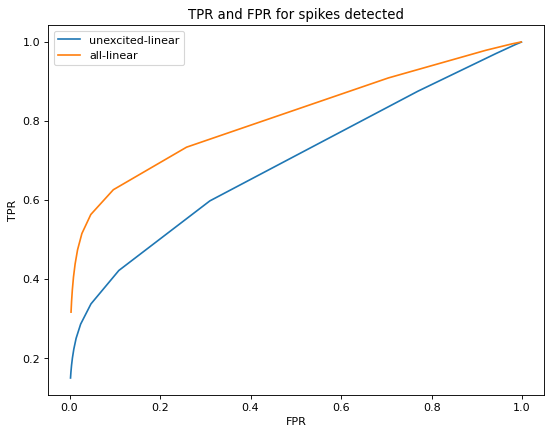

In [114]:
results_load = np.load('results/results_full.npy', allow_pickle=True).item()

# full data linear model vs non-input neurons only
plt.figure(figsize=(8,6), dpi=80)
plt.plot(results_load['fpr_noninput'],results_load['tpr_noninput'],label='unexcited-linear')
plt.plot(results_load['fpr'],results_load['tpr'],label='all-linear')
plt.title('TPR and FPR for spikes detected')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

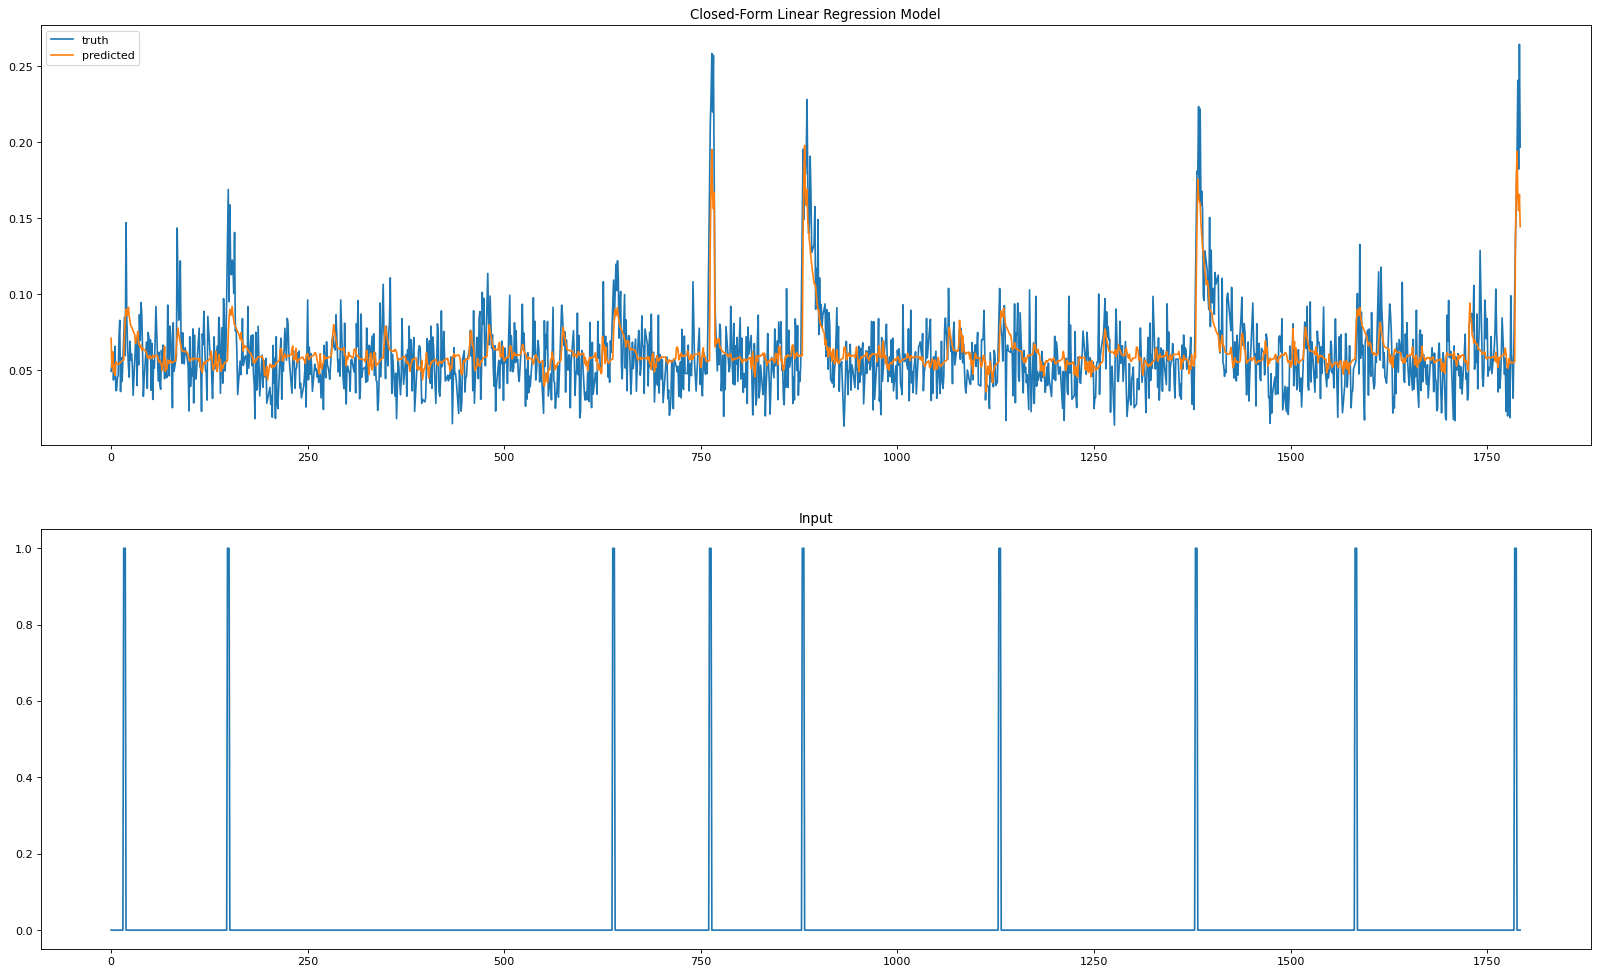

In [115]:
# Closed-Form Linear Regression Model
neuron = removed_neurons[9]
length = 50
t_start = 30

win_len = 25  # observe only 30:55 segments

output_pred = []
output_true = []
input_true = []
segment_marker = []

for i in range(t_start, t_start + win_len):  # looping through 25 segments
    # add all segment's in the interval's neuron data 
    output_pred.extend(x_pred[i][:,neuron])  # segment i's predicted t's data for neuron added to new output_pred
    output_true.extend(x_true[i][:,neuron])  # segment i's true t's data for neuron
    input_true.extend(u_true[i][:,neuron])

    segment_marker.extend(np.nan*np.zeros(len(x_pred[i][:,neuron])-1))  # everything before last t in segment as nan
    segment_marker.extend([0.25,0])  # add 0.25 followed by 0 to mark end of segment
    

# This plot is basically 25 segments (uninterrupted series of t's within k interval from t start) 
# (each segment is 66 at least and can be larger) and their true and predicted  intensity values stitched together
plt.figure(figsize=(25,15), dpi=80)
plt.subplot(2,1,1)
plt.plot(output_true,label='truth')
plt.plot(output_pred,label='predicted')
#plt.plot(segment_marker)
plt.title('Closed-Form Linear Regression Model')
plt.legend()

plt.subplot(2,1,2)
plt.plot(input_true,label='input')
plt.title('Input')
plt.savefig('results/CFS_Linear_Model.pdf')

params is a list of 1 matrices full of 0s of size (502, 502)
A_params is a list of 1 matrices of size (502, 502)
B_params is a list of 1 matrices of size (502, 502)
params is a list of 2 matrices full of 0s of size (502, 502)
A_params is a list of 2 matrices of size (502, 502)
B_params is a list of 2 matrices of size (502, 502)
params is a list of 3 matrices full of 0s of size (502, 502)
A_params is a list of 3 matrices of size (502, 502)
B_params is a list of 3 matrices of size (502, 502)
params is a list of 4 matrices full of 0s of size (502, 502)
A_params is a list of 4 matrices of size (502, 502)
B_params is a list of 4 matrices of size (502, 502)
Singular values of A minus diag is shape of (502,)
Singular values of full A is shape of (502,)


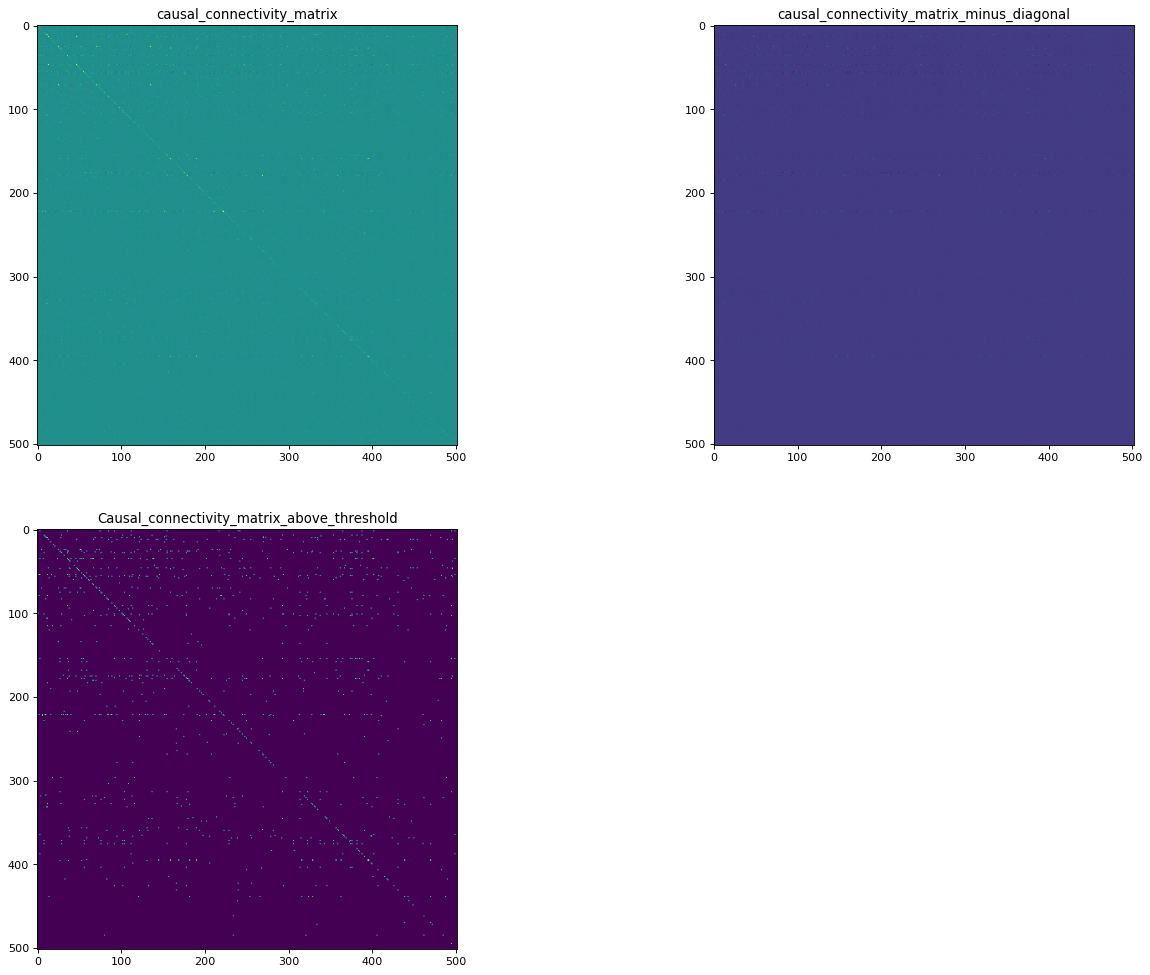

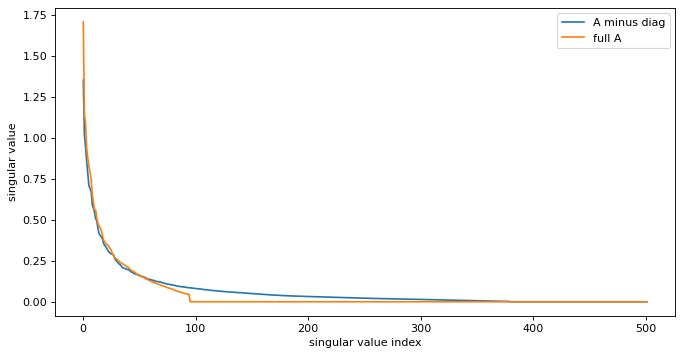

In [116]:
num_neurons = 502
d = num_neurons
A = compute_transfer_matrix(Ahat) #causal connectivity matrix
plt.figure(figsize=(20,15), dpi=80)
plt.subplot(2,2,1)
plt.title('causal_connectivity_matrix')
plt.imshow(A)
plt.clim([-0.2, 0.2])

plt.subplot(2,2,2)
plt.title('causal_connectivity_matrix_minus_diagonal')
plt.imshow(A - np.diag(np.diag(A))) #connectiity matrix - its diagonal

#mean of the largest singular values is used to determine connection coefficient
connection_threshold = 1*np.mean(np.diag(A)) 
A_threshold = (A > connection_threshold).astype(float)
plt.subplot(2,2,3)
plt.title('Causal_connectivity_matrix_above_threshold')
plt.imshow(A > connection_threshold)


plt.figure(figsize=(10,5), dpi=80)
plot_rank_svd(A)

#blue vs orange plot is singular values of A vs A minus diagonals singular values 

In [132]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_neurons = 502
num_lags = 4
init_value = {}
init_value['alpha'] = []
init_value['W'] = []
init_value['beta'] = []
init_value['B'] = []
for i in range(num_lags):
    # return the diagonals and the removed diagonal matrices of the Ahat slices
    diag_alpha, W = diag_off_diag_extraction(
        Ahat[:, num_neurons * (i) :num_neurons * (i+1)])  # add 4 (502=neuron state of x_next, 0:502, 502:1004, 1004:1506, 1506:2008 --> y_session neuron state at previous states at t=0,...,k)
    diag_beta, B = diag_off_diag_extraction(
        Ahat[:, num_neurons * (i+num_lags) :num_neurons * (num_lags+i+1)])  # add 4 (502=neuron state of x_next, 2008:2510, 2510:3012, 3012:3514, 3514:4016 --> u_session inputs at previous states at t=0,...,k)
    
    # alpha and beta are the diagonals of the original Ahat slices, W and B are the Ahat slices with removed diagonals
    init_value['alpha'].insert(0, torch.tensor(diag_alpha).float().to(device))
    init_value['W'].insert(0, torch.tensor(W).float().to(device))
    
    init_value['beta'].insert(0, torch.tensor(diag_beta).float().to(device))
    init_value['B'].insert(0, torch.tensor(B).float().to(device))

V = Ahat[:, num_neurons * (2*num_lags) :num_neurons * (2*num_lags+1)]
print(f"For the closed-form V, we know that Ahat is (502, 4017) so after A and B params are all done, there's only 1 element left for the bias term so V is shape of{V.shape}")
init_value['V'] = torch.squeeze(torch.tensor(V)).float().to(device)

print(init_value['V'].shape)

For the closed-form V, we know that Ahat is (502, 4017) so after A and B params are all done, there's only 1 element left for the bias term so V is shape of(502, 1)
torch.Size([502])


Text(0, 0.5, 'count')

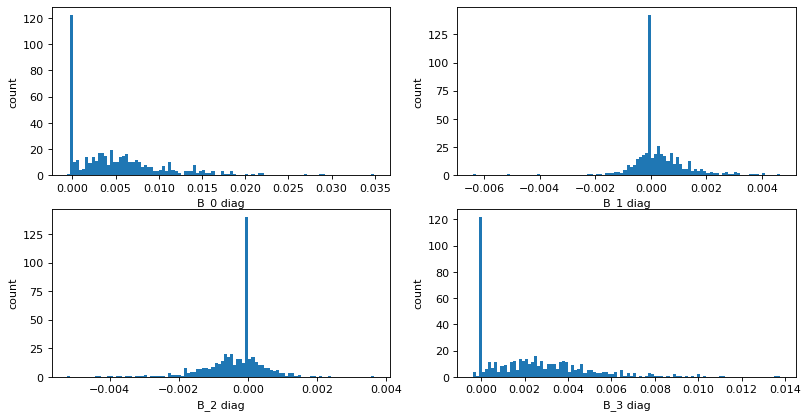

In [194]:
# visualize the distribution of diagonal elements for the B matrices which contain 
# (502=neuron state of x_next, 2008:2510, 2510:3012, 3012:3514, 3514:4016 --> u_session inputs at previous states at t=0,...,k)
plt.figure(figsize=(12,6), dpi=80)
plt.subplot(2,2,1)
plt.hist(to_np(init_value['beta'][0]), bins = 100)
plt.xlabel('B_0 diag')
plt.ylabel('count')
plt.subplot(2,2,2)
plt.hist(to_np(init_value['beta'][1]), bins = 100)
plt.xlabel('B_1 diag')
plt.ylabel('count')
plt.subplot(2,2,3)
plt.hist(to_np(init_value['beta'][2]), bins = 100)
plt.xlabel('B_2 diag')
plt.ylabel('count')
plt.subplot(2,2,4)
plt.hist(to_np(init_value['beta'][3]), bins = 100)
plt.xlabel('B_3 diag')
plt.ylabel('count')

Text(0, 0.5, 'count')

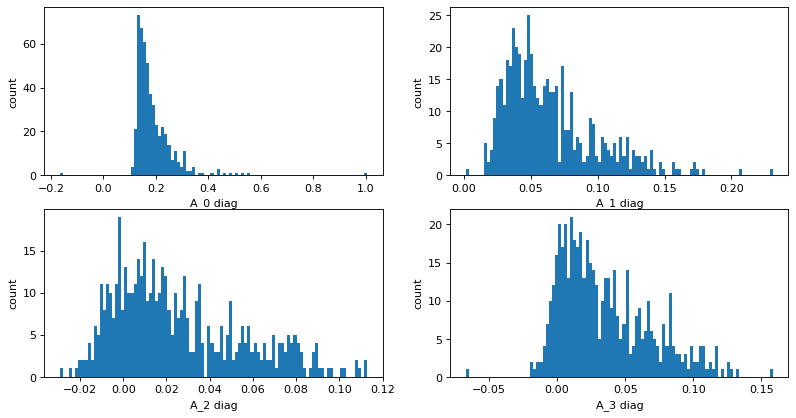

In [195]:
# visualize the distribution of diagonal elements for the A matrices which contain 
# (502=neuron state of x_next, 0:502, 502:1004, 1004:1506, 1506:2008 --> y_session neuron state at previous states at t=0,...,k)
plt.figure(figsize=(12,6), dpi=80)
plt.subplot(2,2,1)
plt.hist(to_np(init_value['alpha'][0]), bins = 100)
plt.xlabel('A_0 diag')
plt.ylabel('count')
plt.subplot(2,2,2)
plt.hist(to_np(init_value['alpha'][1]), bins = 100)
plt.xlabel('A_1 diag')
plt.ylabel('count')
plt.subplot(2,2,3)
plt.hist(to_np(init_value['alpha'][2]), bins = 100)
plt.xlabel('A_2 diag')
plt.ylabel('count')
plt.subplot(2,2,4)
plt.hist(to_np(init_value['alpha'][3]), bins = 100)
plt.xlabel('A_3 diag')
plt.ylabel('count')

In [133]:
# low rank init_value initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_neurons = 502
rank_dim = 502
num_lags = 4
init_value = {}
init_value['alpha'] = []
init_value['W_u'] = []
init_value['W_v'] = []
init_value['beta'] = []
init_value['B_u'] = []
init_value['B_v'] = []
#num_lags is the lag of s historical time steps, s = 0,...,k-1
for i in range(num_lags):
# The Ahat used here is from the closed-form linear solution

    # calculate the low_rank_svd components for the 4 (502,502) 
    # (502=neuron state of x_next, 0:502, 502:1004, 1004:1506, 1506:2008 previous neuron states y_session 
    diag_alpha, Wu, Wv, W_low = low_rank_svd_components_approximation(  # Wv and Bv are the V vectors multiplied with the singular values
        Ahat[:, num_neurons * (i) :num_neurons * (i+1)], rank_dim)
    
    # calculate the low_rank_svd components for the 4 (502,502) 
    # (502=neuron state of x_next, 2008:2510, 2510:3012, 3012:3514, 3514:4016 previous inputs u_session 
    diag_beta, Bu, Bv, B_low = low_rank_svd_components_approximation(
        Ahat[:, num_neurons * (i+num_lags) :num_neurons * (num_lags+i+1)], rank_dim)
    
    init_value['alpha'].insert(0, torch.tensor(diag_alpha).float().to(device))  # each of these lists should have 4 things in them now
    init_value['W_u'].insert(0, torch.tensor(Wu).float().to(device))
    init_value['W_v'].insert(0, torch.tensor(Wv).float().to(device))
    
    init_value['beta'].insert(0, torch.tensor(diag_beta).float().to(device))
    init_value['B_u'].insert(0, torch.tensor(Bu).float().to(device))
    init_value['B_v'].insert(0, torch.tensor(Bv).float().to(device))

# still only 1 element left for bias term from Closed-Form Ahat, so still (502,1)
V = Ahat[:, num_neurons * (2*num_lags) :num_neurons * (2*num_lags+1)]

init_value['V'] = torch.squeeze(torch.tensor(V)).float().to(device)

checkpoint_name: linear_low_rank_502_with_L2_lambda_0
Epoch 0: Train Loss = 0.0011112931873261307, Val Loss = 0.0004628036331268959, L2 Penalty Loss = 212.5172576904297, LR = 0.001
Checkpoint saved at epoch 0 with Val Loss: 0.0005
Epoch 1: Train Loss = 0.00037178476244055975, Val Loss = 0.0002683496495592408, L2 Penalty Loss = 211.49598948160806, LR = 0.001
Checkpoint saved at epoch 1 with Val Loss: 0.0003
Epoch 2: Train Loss = 0.0002404501210548915, Val Loss = 0.0002109475935867522, L2 Penalty Loss = 210.6156438191732, LR = 0.001
Checkpoint saved at epoch 2 with Val Loss: 0.0002
Epoch 3: Train Loss = 0.00019607531188133484, Val Loss = 0.00019205685748602264, L2 Penalty Loss = 209.64079411824545, LR = 0.001
Checkpoint saved at epoch 3 with Val Loss: 0.0002
Epoch 4: Train Loss = 0.0001810197015098917, Val Loss = 0.00018423687652102672, L2 Penalty Loss = 208.93689346313477, LR = 0.001
Checkpoint saved at epoch 4 with Val Loss: 0.0002
Epoch 5: Train Loss = 0.000172951650408019, Val Loss =

<Figure size 960x480 with 0 Axes>

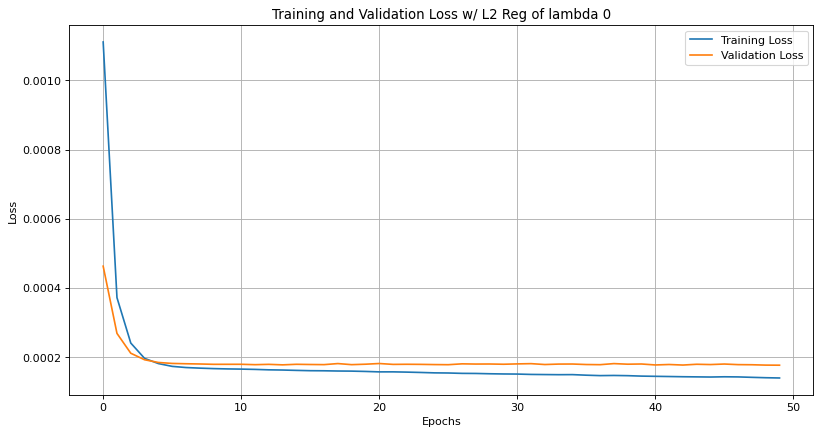

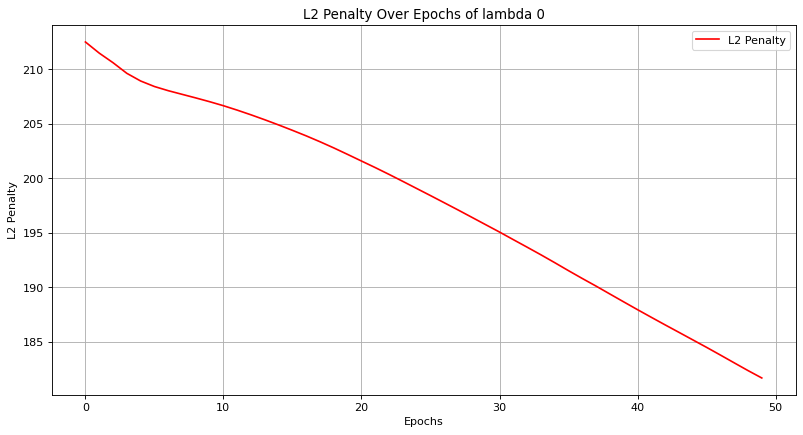

In [134]:
# Example dimensions and settings
num_lags = 4
batch_size = 2000  # how many samples/t's/indices per batch to load in DataLoader
train_start = 5
normalize = 1000
epochs = 50
lambda_val = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate X and U, state and input data 
# Likely need to start at train_start because its AR-k model
X = torch.Tensor(y_session_interp[train_start:,:]/normalize).to(device)
U = torch.Tensor(u_session[train_start:,:]).to(device)
state_dim = X.shape[1] #502
input_dim = U.shape[1] #502

# Create the dataset and dataloader
dataset = TimeseriesDataset(X, U, num_lags)


#train_indices are all the indices minus the test indices
#test_indices were the removed steps from above code

# Split the dataset only if they are valid training and test indices (if the indices have 4 consecutive 1's for training and 0's for test)

train_subset, val_subset = split_dataset(dataset, train_indices[train_start:], num_lags)
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)  # 12 length 24000/2000 ~ 22968 training t's
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)  # 4 length 8000/2000 ~ 6340 test t's


# Initialize the model with the low_rank model/matrices we already pre-computed above and stored in init_value
model = LowRankLinearDynamicModel(state_dim, input_dim, rank_dim, num_lags, init_value)

checkpoint_name = 'linear_low_rank_' + str(rank_dim) + '_with_L2_lambda_' + str(lambda_val)
print('checkpoint_name:', checkpoint_name)

# Train the model
plt.figure(figsize=(12, 6), dpi=80)

train_model(model, train_loader, val_loader, epochs = epochs, lr = 0.001, l2_lambda = lambda_val, checkpoint_name = checkpoint_name)

In [135]:
# Load the best model checkpoint
# Initialize the model
os.chdir("C:/Users/andre/Desktop/active_neuron")


model = LowRankLinearDynamicModel(state_dim, input_dim, rank_dim, num_lags, init_value)
checkpoint_name = 'linear_low_rank_' + str(rank_dim) + '_with_L2_lambda_' + str(lambda_val) + '.pt'
checkpoint_path = 'checkpoints/model_best_' + checkpoint_name  # Update the path and filename as needed
model.load_state_dict(torch.load(checkpoint_path))  # load the model that had the lowest val loss
model.eval()  # Set the model to evaluation mode

init_value = {}
init_value['alpha'] = []
init_value['W_u'] = []
init_value['W_v'] = []
init_value['beta'] = []
init_value['B_u'] = []
init_value['B_v'] = []
init_value['V'] = []

Ahat_list = [] #will concatenate this list, W/A, B, and V

# expand and convert torch.Size([502]) to np (502, 1), and insert it at the top
# by the end, v will be on bottom, above it will be B, above it will be A
Ahat_list.insert(0, np.expand_dims(to_np(model.V), axis = 1))
init_value['V'].insert(0, to_np(model.V))


#(502=neuron state of x_next, 2008:2510, 2510:3012, 3012:3514, 3514:4016 previous inputs u_session)
for Bu_k, Bv_k, betak in zip(model.B_u, model.B_v, model.beta):
    init_value['beta'].insert(0, to_np(betak))  # OG diagonals of each (502,502) CFS Linear Ahatmatrix B slice, before low rank
    init_value['B_u'].insert(0, to_np(Bu_k))  # U vectors for each low rank B matrix of each 
    init_value['B_v'].insert(0, to_np(Bv_k))  # V vectors time S singular values for each low rank B matrix
    Bk = torch.mm(Bu_k, Bv_k.T)  # reconstruct each low rank B matrix, (502,5) @ (5,502) = (502,502)

    # add the corresponding pre-low rank CFS Linear Ahat OG diagonals back to each reconstructed low_rank matrices
    # insert the B = U @ V.T + D (502,502) to top of Ahat
    Ahat_list.insert(0, to_np(singular_value_norm(Bk + torch.diag(betak))))
    
for Wu_k, Wv_k, alphak in zip(model.W_u, model.W_v, model.alpha):
    init_value['alpha'].insert(0, to_np(alphak))  # OG diagonals of each (502,502) CFS Linear Ahat matrix A slice, before low rank
    init_value['W_u'].insert(0, to_np(Wu_k))  # U vectors for each low rank A matrix of each 
    init_value['W_v'].insert(0, to_np(Wv_k))  # V vectors time S singular values for each low rank A matrix
    Wk = torch.mm(Wu_k, Wv_k.T)  # reconstruct each low rank A matrix, (502,5) @ (5,502) = (502,502)
    
    # add the corresponding pre-low rank CFS Linear Ahat OG diagonals back to each reconstructed low_rank matrices
    # insert the A = U @ V.T + D (502,502) to top of Ahat
    Ahat_list.insert(0, to_np(singular_value_norm(Wk + torch.diag(alphak))))

# concatenate them into a vertical np array of the A, B, V matrices in that order
# So Ahat_gd is basically the W of the trained low rank model
Ahat_gd = np.concatenate(Ahat_list, axis = 1)

#Ahat_gd is theta matrix on page 24

np.save('Ahat_D_U_V_low_rank_' + str(rank_dim) + '.npz', init_value)
np.save('Ahat_low_rank_' + str(rank_dim) + '.npy', Ahat_gd)

torch.Size([502, 502])
torch.Size([502])
Singular values of A minus diag is shape of (502,)
Singular values of full A is shape of (502,)


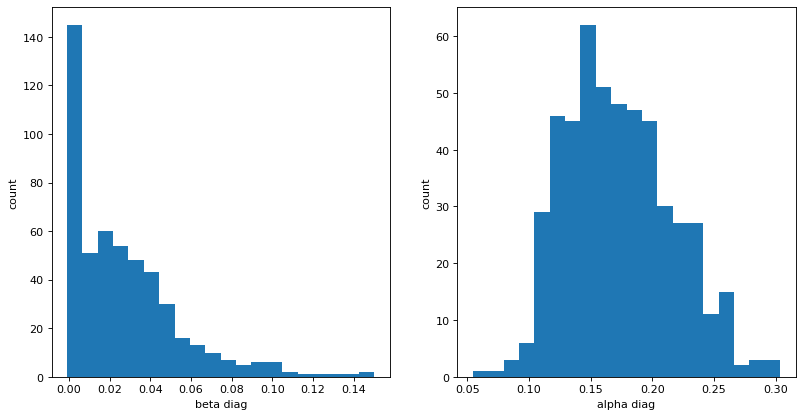

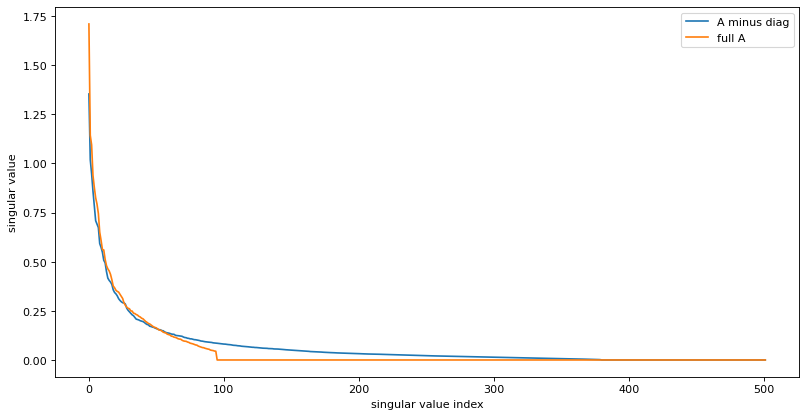

In [199]:
print(torch.diag(betak).shape)
print(betak.shape)



plt.figure(figsize=(12, 6), dpi=80)

plt.subplot(1, 2, 1)
plt.hist(to_np(betak),bins=20)
plt.ylabel('count')
plt.xlabel('beta diag')

plt.subplot(1, 2, 2)
plt.hist(to_np(alphak),bins=20)
plt.ylabel('count')
plt.xlabel('alpha diag')


plt.figure(figsize=(12,6), dpi=80)
plot_rank_svd(A)

params is a list of 1 matrices full of 0s of size (502, 502)
A_params is a list of 1 matrices of size (502, 502)
B_params is a list of 1 matrices of size (502, 502)
params is a list of 2 matrices full of 0s of size (502, 502)
A_params is a list of 2 matrices of size (502, 502)
B_params is a list of 2 matrices of size (502, 502)
params is a list of 3 matrices full of 0s of size (502, 502)
A_params is a list of 3 matrices of size (502, 502)
B_params is a list of 3 matrices of size (502, 502)
params is a list of 4 matrices full of 0s of size (502, 502)
A_params is a list of 4 matrices of size (502, 502)
B_params is a list of 4 matrices of size (502, 502)


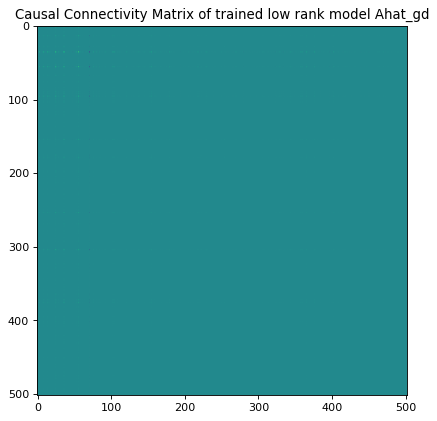

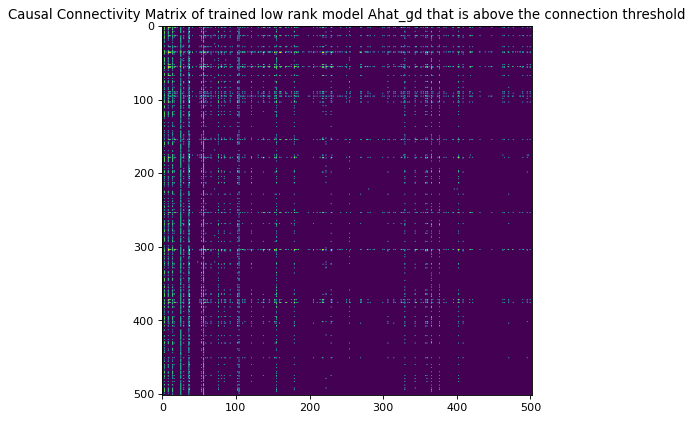

In [200]:
num_neurons = 502
d = num_neurons
A = compute_transfer_matrix(Ahat_gd)
plt.figure(figsize=(12,6), dpi=80)
plt.title('Causal Connectivity Matrix of trained low rank model Ahat_gd')
plt.imshow(A)

connection_threshold = 1*np.mean(np.diag(A))
A_threshold = (A > connection_threshold).astype(float)
plt.figure(figsize=(12,6), dpi=80)
plt.title('Causal Connectivity Matrix of trained low rank model Ahat_gd that is above the connection threshold')
plt.imshow(A > connection_threshold)

In [140]:
# Low Rank Trained model used to make predictions
x_pred = []
x_true = []
u_true = []
r2 = [] 
idx = -1
ark_order = 4
normalize = 1000
new_segment = True
segment_pred = []
segment_start = -1
for t in range(train_indices.shape[0]):
    if test_indices[t] == 1: #if it is in test set
        if new_segment:
            segment_pred = []
            new_segment = False
            segment_start = t
            x_past = []
            x_pred.append([])
            x_true.append([])
            u_true.append([])
            idx += 1  # index of segments
        if t < segment_start + ark_order:  
        #if t is within ark_order of segment start, add it to x_past, which should be (2008,) at end of ark_order
            x_past.append(y_session_interp[t,:].copy().flatten()/normalize)
        
        #if not new_segment, and if t is outside current segment
        else:
            z = np.array(x_past).flatten()  # z should be (2008,)
            z = np.concatenate((z,u_session[t-ark_order:t,:].copy().flatten(),np.ones(1)))  # z should now be (4017,)

            # (502, 4017) @ (4017, ) = (502, ) x_next
            x_next = Ahat_gd @ z
            x_past.pop(0)  # pop oldest y_session_interp[t,:] (502,) 
            x_past.append(x_next.copy()) #add the new predicted x_next (502,)
            x_pred[idx].append(x_next.copy())
            x_true[idx].append(y_session_interp[t,:].copy().flatten()/normalize)
            u_true[idx].append(u_session[t,:].copy().flatten())
    else:  #if current t is not part of test set, a new segment should start
        new_segment = True

print(f"x_pred shape {len(x_pred)}")
print(f"x_true shape {len(x_true)}")
print(f"u_true shape {len(u_true)}")

mse_losses = []
for i in range(len(x_pred)):  # loop through 82 segments
    x_pred[i] = np.array(x_pred[i])
    x_true[i] = np.array(x_true[i])
    u_true[i] = np.array(u_true[i])
    mse_losses.append((np.square(x_pred[i] - x_true[i])).mean())
    r2.append(r2_score(x_true[i], x_pred[i]))
print('mse:', sum(mse_losses)/len(mse_losses))
print('r2:', sum(r2)/len(r2))

x_pred shape 82
x_true shape 82
u_true shape 82
mse: 0.0005038587488179268
r2: -1.6250365486662626


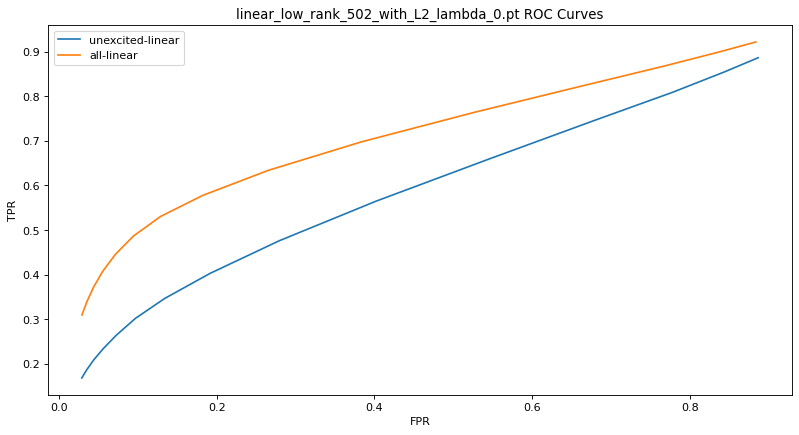

In [137]:
tpr = []
fpr = []
results_name = checkpoint_name
thresholds = np.linspace(-2,5,15)

for thresholds_idx in range(len(thresholds)):
    tp_total = 0
    fp_total = 0
    p_total = 0
    n_total = 0

    for neuron in range(u_session.shape[1]):
        output_pred = []
        output_true = []
        for i in range(len(x_true)):
            output_pred.extend(x_pred[i][:,neuron])
            output_true.extend(x_true[i][:,neuron])
        output_pred = np.array(output_pred)
        output_true = np.array(output_true)
    
        mean_threshold = np.median(output_true)
        lower_tail_idx = (output_true < mean_threshold)
        lower_tail_data = output_true[lower_tail_idx]
        lower_tail_std = np.std(lower_tail_data)
        true_spike_threshold = mean_threshold + 6*lower_tail_std
        detect_spike_threshold = mean_threshold + thresholds[thresholds_idx]*lower_tail_std

        predicted_spikes = (output_pred > detect_spike_threshold)
        true_spikes = (output_true > true_spike_threshold)
        tp_total += np.sum(np.logical_and(predicted_spikes,true_spikes))
        fp_total += np.sum(np.logical_and(predicted_spikes,~true_spikes))
        p_total += np.sum(true_spikes)
        n_total += np.sum(~true_spikes)

    tpr.append(tp_total / p_total)
    fpr.append(fp_total / n_total)


tpr_noninput = []
fpr_noninput = []
thresholds = np.linspace(-2,5,15)

for thresholds_idx in range(len(thresholds)):
    tp_total = 0
    fp_total = 0
    p_total = 0
    n_total = 0

    for neuron in range(u_session.shape[1]):
        output_pred = []
        output_true = []
        for i in range(len(x_true)):
            if np.sum(u_true[i][:,neuron]) == 0:
                output_pred.extend(x_pred[i][:,neuron])
                output_true.extend(x_true[i][:,neuron])
        output_pred = np.array(output_pred)
        output_true = np.array(output_true)
    
        mean_threshold = np.median(output_true)
        lower_tail_idx = (output_true < mean_threshold)
        lower_tail_data = output_true[lower_tail_idx]
        lower_tail_std = np.std(lower_tail_data)
        true_spike_threshold = mean_threshold + 6*lower_tail_std
        detect_spike_threshold = mean_threshold + thresholds[thresholds_idx]*lower_tail_std

        predicted_spikes = (output_pred > detect_spike_threshold)
        true_spikes = (output_true > true_spike_threshold)
        tp_total += np.sum(np.logical_and(predicted_spikes,true_spikes))
        fp_total += np.sum(np.logical_and(predicted_spikes,~true_spikes))
        p_total += np.sum(true_spikes)
        n_total += np.sum(~true_spikes)

    tpr_noninput.append(tp_total / p_total)
    fpr_noninput.append(fp_total / n_total)
    
results = {}
results['fpr'] = fpr
results['tpr'] = tpr
results['fpr_noninput'] = fpr_noninput
results['tpr_noninput'] = tpr_noninput
np.save('results/' + results_name + '.npy', results)

results_load = np.load('results/' + results_name + '.npy', allow_pickle=True).item()

# full data linear model vs non-input neurons only

plt.figure(figsize=(12,6), dpi=80)
plt.title(f"{results_name} ROC Curves")
plt.plot(results_load['fpr_noninput'],results_load['tpr_noninput'],label='unexcited-linear')
plt.plot(results_load['fpr'],results_load['tpr'],label='all-linear')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

In [42]:
tprs = []
fprs = []

results_name = 'linear_low_rank_35_with_L2_lambda_0.pt'
threshold = 0


for neuron in range(u_session.shape[1]):
    output_pred = []
    output_true = []
    for i in range(len(x_true)):  #82 segments
        output_pred.extend(x_pred[i][:,neuron])
        output_true.extend(x_true[i][:,neuron])
    output_pred = np.array(output_pred)
    output_true = np.array(output_true)

    mean_threshold = np.median(output_true)
    lower_tail_idx = (output_true < mean_threshold)
    lower_tail_data = output_true[lower_tail_idx]
    lower_tail_std = np.std(lower_tail_data)
    true_spike_threshold = mean_threshold + 6*lower_tail_std
    detect_spike_threshold = mean_threshold + threshold*lower_tail_std

    predicted_spikes = (output_pred > detect_spike_threshold)
    true_spikes = (output_true > true_spike_threshold)
    tp = np.sum(np.logical_and(predicted_spikes,true_spikes))
    fp = np.sum(np.logical_and(predicted_spikes,~true_spikes))
    p = np.sum(true_spikes)
    n = np.sum(~true_spikes)
    tpr = tp / p  # TPR is recall
    fpr = fp / n
    tprs.append(tpr)
    fprs.append(fpr)

print(f"length of tprs is: {len(tprs)}")
print(f"tprs looks like: {tprs}")
print(f"length of fprs is: {len(fprs)}")
print(f"fprs looks like: {fprs}")




tpr_noninputs = []
fpr_noninputs = []
stimmed_neurons = []
nonstimmed_neurons = []

for neuron in range(u_session.shape[1]):
    output_pred = []
    output_true = []
    for i in range(len(x_true)):
        if np.sum(u_true[i][:,neuron]) == 0:
            # nonstimmed_neurons.append(neuron)
            output_pred.extend(x_pred[i][:,neuron])
            output_true.extend(x_true[i][:,neuron])
        # else:
        #     stimmed_neurons.append(neuron)
    output_pred = np.array(output_pred)
    output_true = np.array(output_true)

    mean_threshold = np.median(output_true)
    lower_tail_idx = (output_true < mean_threshold)
    lower_tail_data = output_true[lower_tail_idx]
    lower_tail_std = np.std(lower_tail_data)
    true_spike_threshold = mean_threshold + 6*lower_tail_std
    detect_spike_threshold = mean_threshold + threshold*lower_tail_std

    predicted_spikes = (output_pred > detect_spike_threshold)
    true_spikes = (output_true > true_spike_threshold)
    tp_noninput = np.sum(np.logical_and(predicted_spikes,true_spikes))
    fp_noninput = np.sum(np.logical_and(predicted_spikes,~true_spikes))
    p_noninput = np.sum(true_spikes)
    n_noninput = np.sum(~true_spikes)
    tpr_noninput = tp_noninput / p_noninput
    fpr_noninput = fp_noninput / n_noninput
    
    tpr_noninputs.append(tpr_noninput)
    fpr_noninputs.append(fpr_noninput)

print(f"length of tprs_noninput is: {len(tpr_noninputs)}")
print(f"tprs_noninput looks like: {tpr_noninputs}")
print(f"length of fprs_noninput is: {len(fpr_noninputs)}")
print(f"fprs_noninput looks like: {fpr_noninputs}")
# print(len(nonstimmed_neurons))
# print(len(stimmed_neurons))

# plt.figure(figsize=(12,6), dpi=80)
# plt.title(f"{results_name} ROC Curves")
# plt.plot(results_load['fpr_noninput'],results_load['tpr_noninput'],label='unexcited-linear')
# plt.plot(results_load['fpr'],results_load['tpr'],label='all-linear')
# plt.xlabel('FPR')
# plt.ylabel('TPR')
# plt.legend()
# plt.show()




# loop through 502 neurons, loop through 82 segments inside ---> 502 * 82 = 41164
# 36055 non stimmed neurons, 5109 stimmed neurons ---> 36055 + 5109 = 41164

length of tprs is: 502
tprs looks like: [0.9954128440366973, 0.9418070444104135, 0.8928571428571429, 0.605296343001261, 0.9375, 0.8513513513513513, 0.9144385026737968, 0.75, 0.9230769230769231, 0.9785604900459418, 0.8008948545861297, 0.9629629629629629, 0.7153846153846154, 0.7516447368421053, 0.7569444444444444, 0.6170212765957447, 0.7675438596491229, 0.9392265193370166, 0.7157360406091371, 0.8895184135977338, 0.8141592920353983, 0.8639455782312925, 0.7964601769911505, 0.5780590717299579, 0.7756410256410257, 0.969047619047619, 0.9135802469135802, 0.8317152103559871, 0.8679245283018868, 0.9320388349514563, 0.8050847457627118, 0.6574074074074074, 0.8554216867469879, 0.9218241042345277, 0.868421052631579, 0.8688524590163934, 0.6946983546617916, 0.7368421052631579, 0.9421052631578948, 0.8161616161616162, 0.8839285714285714, 0.7551020408163265, 0.7945205479452054, 0.9738562091503268, 0.9655172413793104, 0.6136363636363636, 0.5535714285714286, 0.7615131578947368, 0.821917808219178, 0.9468503

mean is: 0.8122519232683347


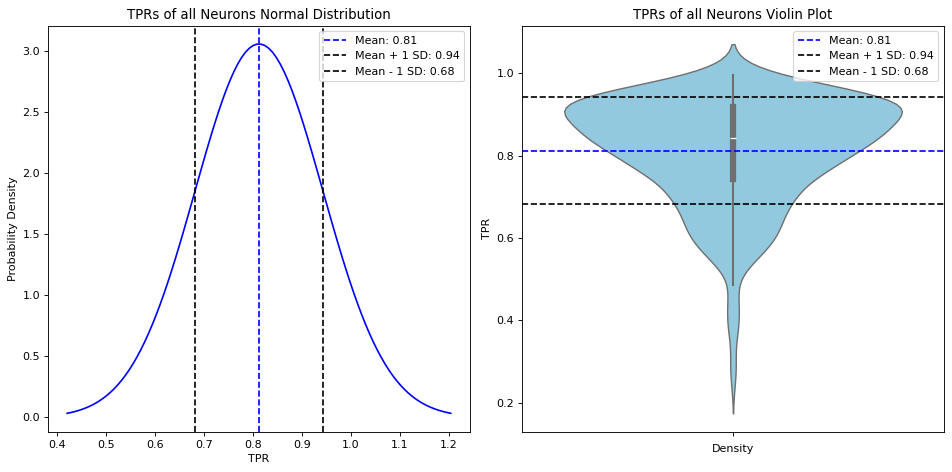

In [82]:
mean = np.mean(tprs)
print(f"mean is: {mean}")
std_dev = np.std(tprs)

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(12,6), dpi=80)

# Subplot 1: Normal Distribution Plot
x_values = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 100)
y_values = norm.pdf(x_values, mean, std_dev)

ax[0].plot(x_values, y_values, color='blue')
ax[0].axvline(mean, color='blue', linestyle='--', label=f'Mean: {mean:.2f}')
ax[0].axvline(mean + std_dev, color='black', linestyle='--', label=f'Mean + 1 SD: {mean + std_dev:.2f}')
ax[0].axvline(mean - std_dev, color='black', linestyle='--', label=f'Mean - 1 SD: {mean - std_dev:.2f}')

ax[0].set_xlabel('TPR')
ax[0].set_ylabel('Probability Density')
ax[0].set_title('TPRs of all Neurons Normal Distribution')
ax[0].legend()

# Subplot 2: Violin Plot
sns.violinplot(data=tprs, color='skyblue', ax=ax[1])

ax[1].axhline(mean, color='blue', linestyle='--', label=f'Mean: {mean:.2f}')
ax[1].axhline(mean + std_dev, color='black', linestyle='--', label=f'Mean + 1 SD: {mean + std_dev:.2f}')
ax[1].axhline(mean - std_dev, color='black', linestyle='--', label=f'Mean - 1 SD: {mean - std_dev:.2f}')

ax[1].set_xlabel('Density')
ax[1].set_ylabel('TPR')
ax[1].set_title('TPRs of all Neurons Violin Plot')
ax[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

mean is: 0.5906652408239262


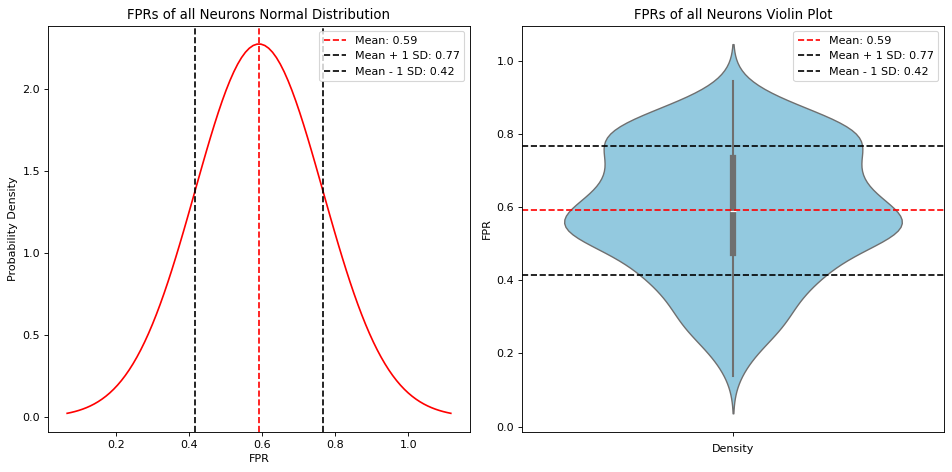

In [88]:
mean = np.mean(fprs)
print(f"mean is: {mean}")
std_dev = np.std(fprs)

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(12,6), dpi=80)

# Subplot 1: Normal Distribution Plot
x_values = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 100)
y_values = norm.pdf(x_values, mean, std_dev)

ax[0].plot(x_values, y_values, color='red')
ax[0].axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')
ax[0].axvline(mean + std_dev, color='black', linestyle='--', label=f'Mean + 1 SD: {mean + std_dev:.2f}')
ax[0].axvline(mean - std_dev, color='black', linestyle='--', label=f'Mean - 1 SD: {mean - std_dev:.2f}')

ax[0].set_xlabel('FPR')
ax[0].set_ylabel('Probability Density')
ax[0].set_title('FPRs of all Neurons Normal Distribution')
ax[0].legend()

# Subplot 2: Violin Plot
sns.violinplot(data=fprs, color='skyblue', ax=ax[1])

ax[1].axhline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')
ax[1].axhline(mean + std_dev, color='black', linestyle='--', label=f'Mean + 1 SD: {mean + std_dev:.2f}')
ax[1].axhline(mean - std_dev, color='black', linestyle='--', label=f'Mean - 1 SD: {mean - std_dev:.2f}')

ax[1].set_xlabel('Density')
ax[1].set_ylabel('FPR')
ax[1].set_title('FPRs of all Neurons Violin Plot')
ax[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

mean is: 0.7555817795623315


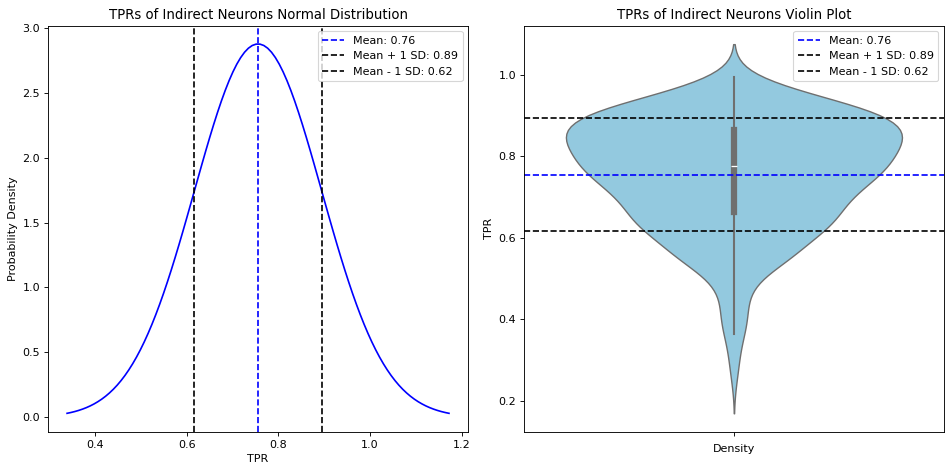

In [89]:
mean = np.mean(tpr_noninputs)
print(f"mean is: {mean}")
std_dev = np.std(tpr_noninputs)

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(12,6), dpi=80)

# Subplot 1: Normal Distribution Plot
x_values = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 100)
y_values = norm.pdf(x_values, mean, std_dev)

ax[0].plot(x_values, y_values, color='blue')
ax[0].axvline(mean, color='blue', linestyle='--', label=f'Mean: {mean:.2f}')
ax[0].axvline(mean + std_dev, color='black', linestyle='--', label=f'Mean + 1 SD: {mean + std_dev:.2f}')
ax[0].axvline(mean - std_dev, color='black', linestyle='--', label=f'Mean - 1 SD: {mean - std_dev:.2f}')

ax[0].set_xlabel('TPR')
ax[0].set_ylabel('Probability Density')
ax[0].set_title('TPRs of Indirect Neurons Normal Distribution')
ax[0].legend()

# Subplot 2: Violin Plot
sns.violinplot(data=tpr_noninputs, color='skyblue', ax=ax[1])

ax[1].axhline(mean, color='blue', linestyle='--', label=f'Mean: {mean:.2f}')
ax[1].axhline(mean + std_dev, color='black', linestyle='--', label=f'Mean + 1 SD: {mean + std_dev:.2f}')
ax[1].axhline(mean - std_dev, color='black', linestyle='--', label=f'Mean - 1 SD: {mean - std_dev:.2f}')

ax[1].set_xlabel('Density')
ax[1].set_ylabel('TPR')
ax[1].set_title('TPRs of Indirect Neurons Violin Plot')
ax[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

mean is: 0.6305287000741175


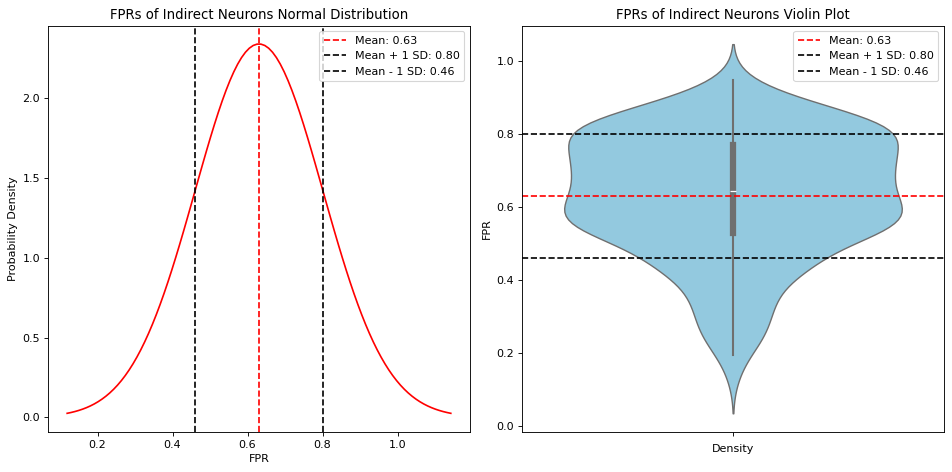

In [90]:
mean = np.mean(fpr_noninputs)
print(f"mean is: {mean}")
std_dev = np.std(fpr_noninputs)

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(12,6), dpi=80)

# Subplot 1: Normal Distribution Plot
x_values = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 100)
y_values = norm.pdf(x_values, mean, std_dev)

ax[0].plot(x_values, y_values, color='red')
ax[0].axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')
ax[0].axvline(mean + std_dev, color='black', linestyle='--', label=f'Mean + 1 SD: {mean + std_dev:.2f}')
ax[0].axvline(mean - std_dev, color='black', linestyle='--', label=f'Mean - 1 SD: {mean - std_dev:.2f}')

ax[0].set_xlabel('FPR')
ax[0].set_ylabel('Probability Density')
ax[0].set_title('FPRs of Indirect Neurons Normal Distribution')
ax[0].legend()

# Subplot 2: Violin Plot
sns.violinplot(data=fpr_noninputs, color='skyblue', ax=ax[1])

ax[1].axhline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')
ax[1].axhline(mean + std_dev, color='black', linestyle='--', label=f'Mean + 1 SD: {mean + std_dev:.2f}')
ax[1].axhline(mean - std_dev, color='black', linestyle='--', label=f'Mean - 1 SD: {mean - std_dev:.2f}')

ax[1].set_xlabel('Density')
ax[1].set_ylabel('FPR')
ax[1].set_title('FPRs of Indirect Neurons Violin Plot')
ax[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [8]:
os.chdir("C:/Users/andre/Desktop/active_neuron")

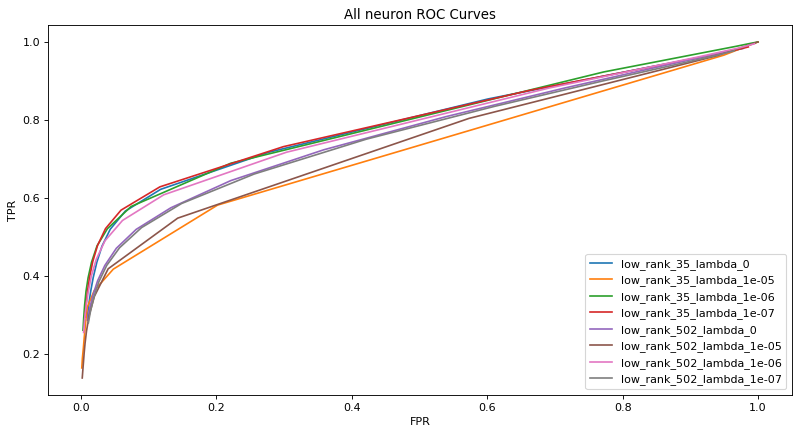

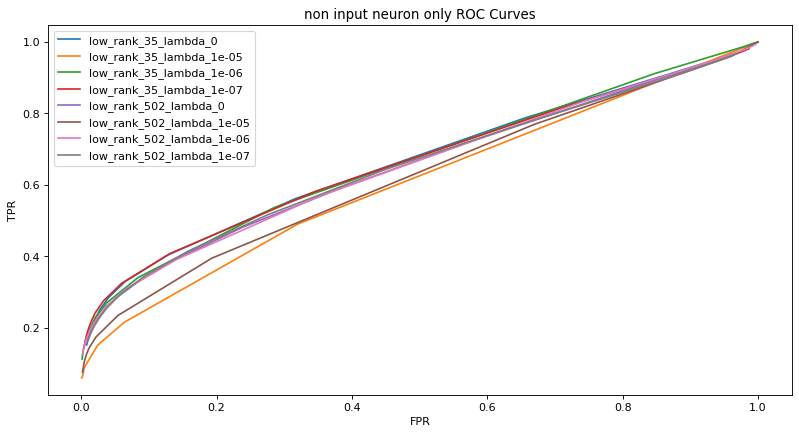

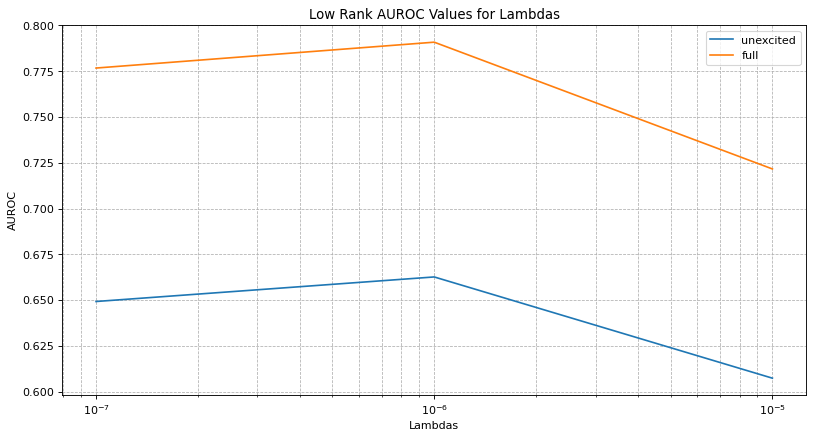

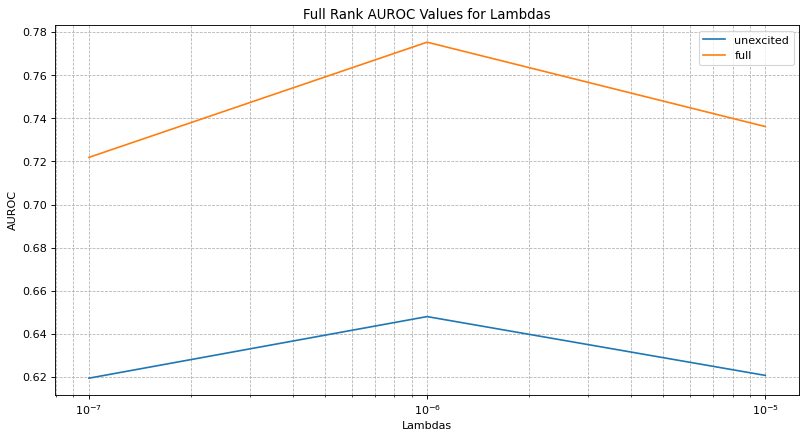

In [99]:
results_names = ['linear_low_rank_35_with_L2_lambda_0.pt', 'linear_low_rank_35_with_L2_lambda_1e-05.pt', 'linear_low_rank_35_with_L2_lambda_1e-06.pt', 'linear_low_rank_35_with_L2_lambda_1e-07.pt', 'linear_low_rank_502_with_L2_lambda_0.pt', 'linear_low_rank_502_with_L2_lambda_1e-05.pt', 'linear_low_rank_502_with_L2_lambda_1e-06.pt', 'linear_low_rank_502_with_L2_lambda_1e-07.pt']


plt.figure(figsize=(12,6), dpi=80)

aurocs_noninput = []
aurocs = []

for results_name in results_names:

    results_load = np.load('results/' + results_name + '.npy', allow_pickle=True).item()

    sorted_indices = np.argsort(results_load['fpr'])
    fpr_sorted = np.array(results_load['fpr'])[sorted_indices]
    tpr_sorted = np.array(results_load['tpr'])[sorted_indices]
    
    # Calculate AUROC for both curves using numerical integration
    auroc = np.trapz(tpr_sorted, fpr_sorted)
    
    # Store the AUROC values
    aurocs.append(auroc)

    plt.plot(results_load['fpr'],results_load['tpr'],label='all-linear')

plt.title(f"All neuron ROC Curves")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(['low_rank_35_lambda_0', 'low_rank_35_lambda_1e-05', 'low_rank_35_lambda_1e-06', 'low_rank_35_lambda_1e-07', 'low_rank_502_lambda_0', 'low_rank_502_lambda_1e-05', 'low_rank_502_lambda_1e-06', 'low_rank_502_lambda_1e-07'])
plt.show()




plt.figure(figsize=(12,6), dpi=80)

for results_name in results_names:

    results_load = np.load('results/' + results_name + '.npy', allow_pickle=True).item()
    
    # Sort FPR and TPR to ensure proper integration
    sorted_indices_noninput = np.argsort(results_load['fpr_noninput'])
    fpr_noninput_sorted = np.array(results_load['fpr_noninput'])[sorted_indices_noninput]
    tpr_noninput_sorted = np.array(results_load['tpr_noninput'])[sorted_indices_noninput]
    
    # Calculate AUROC for both curves using numerical integration
    auroc_noninput = np.trapz(tpr_noninput_sorted, fpr_noninput_sorted)
    
    # Store the AUROC values
    aurocs_noninput.append(auroc_noninput)

    plt.plot(results_load['fpr_noninput'],results_load['tpr_noninput'],label='unexcited-linear')

plt.title(f"non input neuron only ROC Curves")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(['low_rank_35_lambda_0', 'low_rank_35_lambda_1e-05', 'low_rank_35_lambda_1e-06', 'low_rank_35_lambda_1e-07', 'low_rank_502_lambda_0', 'low_rank_502_lambda_1e-05', 'low_rank_502_lambda_1e-06', 'low_rank_502_lambda_1e-07'])
plt.show()


l2_lambdas = [1e-5, 1e-6, 1e-7]
plt.figure(figsize=(12,6), dpi=80)

plt.plot(l2_lambdas, aurocs_noninput[1:4])
plt.plot(l2_lambdas, aurocs[1:4])

plt.title(f"Low Rank AUROC Values for Lambdas")
plt.xlabel('Lambdas')
plt.ylabel('AUROC')

plt.xscale('log')
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.legend(["unexcited", "full"])
plt.show()




l2_lambdas = [1e-5, 1e-6, 1e-7]
plt.figure(figsize=(12,6), dpi=80)

plt.plot(l2_lambdas, aurocs_noninput[5:8])
plt.plot(l2_lambdas, aurocs[5:8])

plt.title(f"Full Rank AUROC Values for Lambdas")
plt.xlabel('Lambdas')
plt.ylabel('AUROC')

plt.xscale('log')
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.legend(["unexcited", "full"])
plt.show()

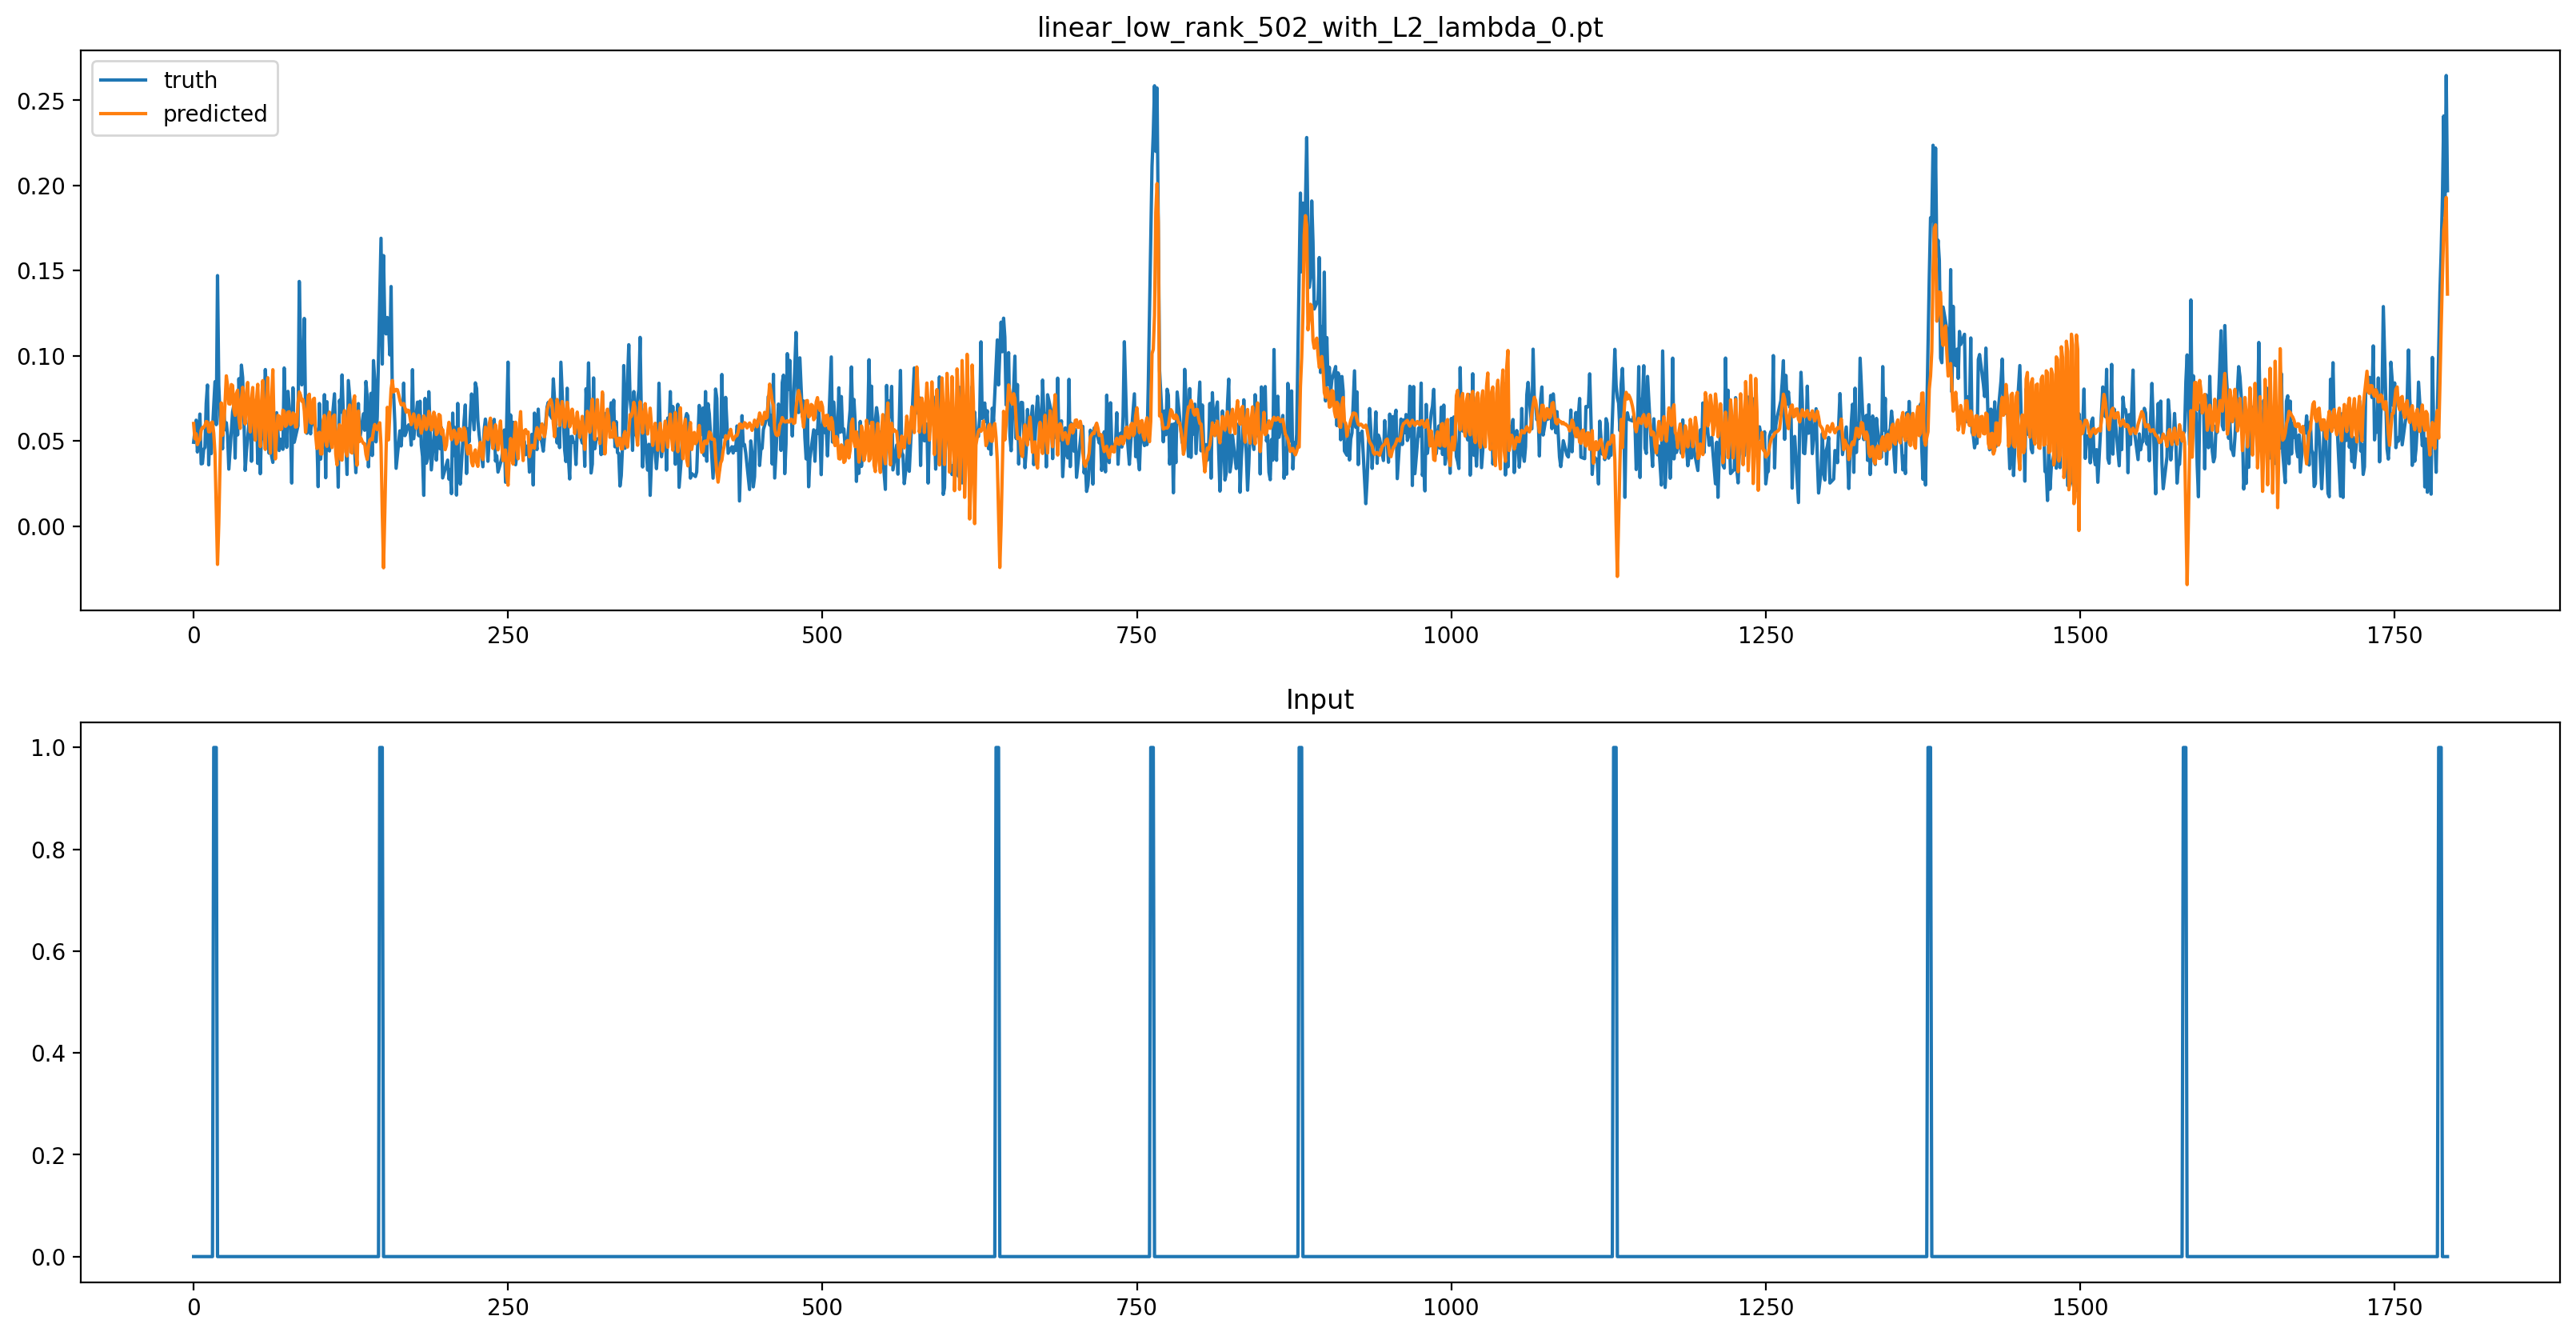

In [141]:
neuron = removed_neurons[9]
length = 50
t_start = 30

win_len = 25

output_pred = []
output_true = []
input_true = []
segment_marker = []

for i in range(t_start, t_start + win_len):
    output_pred.extend(x_pred[i][:,neuron])
    #output_pred.append(np.nan)
    output_true.extend(x_true[i][:,neuron])
    #output_true.append(np.nan)
    input_true.extend(u_true[i][:,neuron])
    #input_true.append(np.nan)
    segment_marker.extend(np.nan*np.zeros(len(x_pred[i][:,neuron])-1))
    segment_marker.extend([0.25,0])
    
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(output_true,label='truth')
plt.plot(output_pred,label='predicted')
#plt.plot(segment_marker)
plt.title(results_name)
plt.legend()

plt.subplot(2,1,2)
plt.plot(input_true,label='input')
plt.title('Input')
plt.savefig('results/' + results_name + '.pdf')

Text(0.5, 1.0, 'Input')

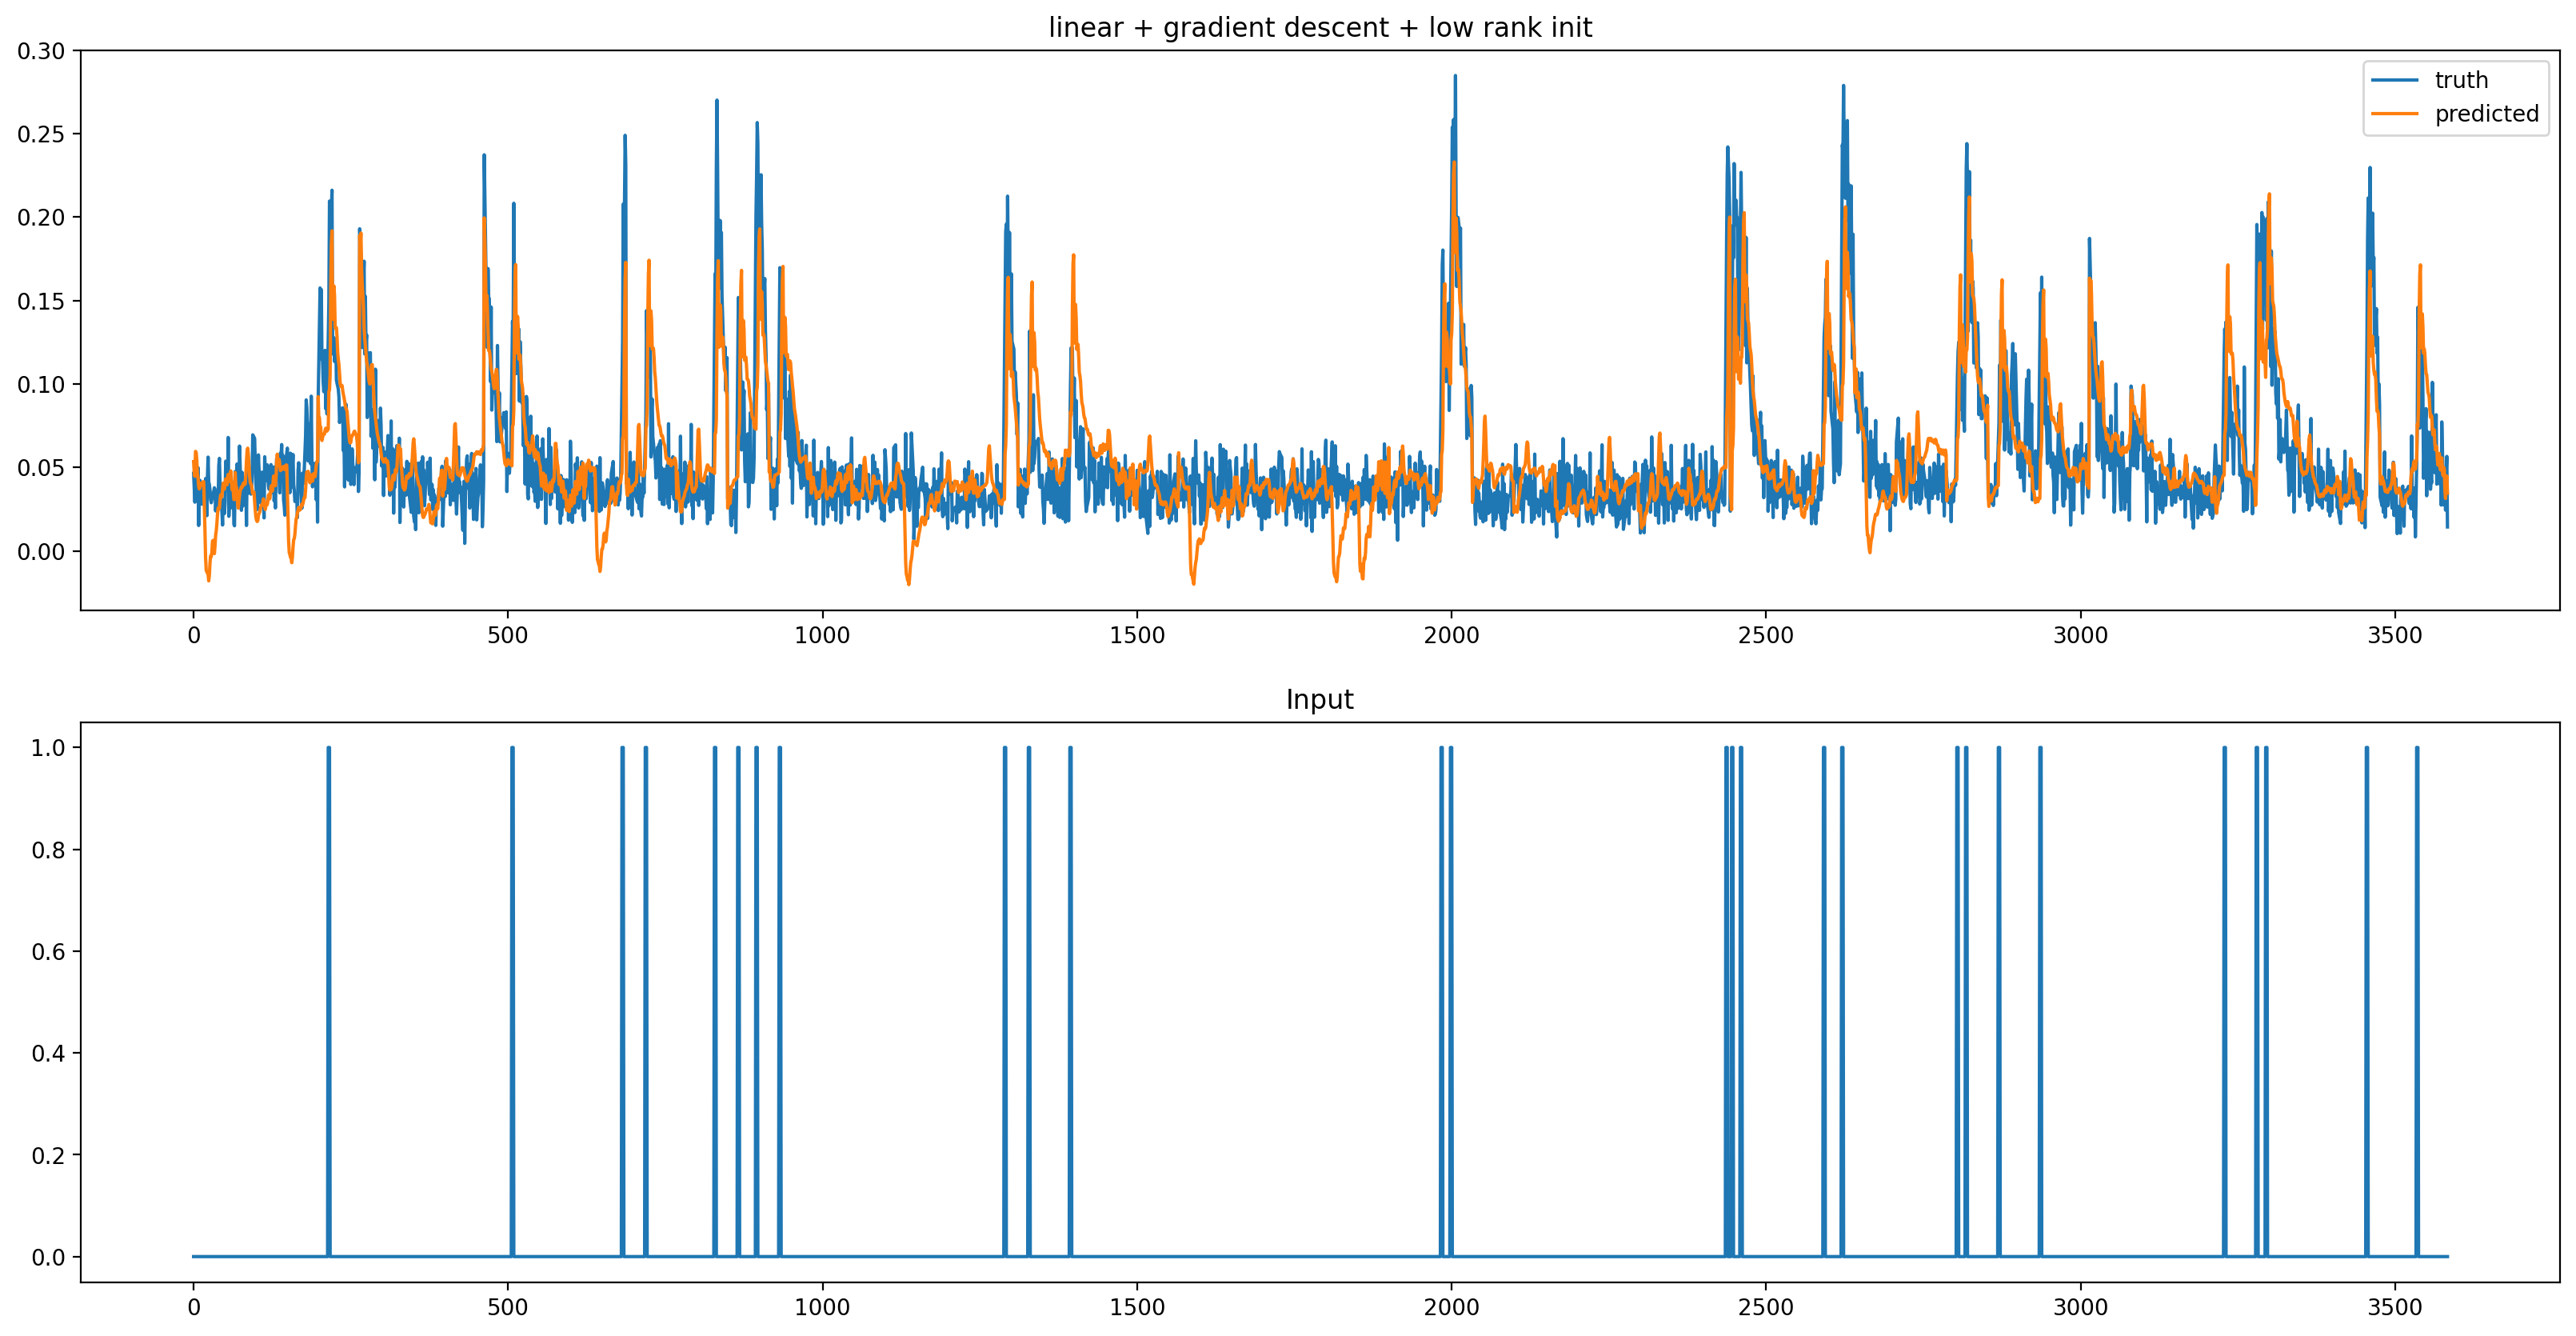

In [142]:
# linear model + gd + low rank init + low rank 35
neuron = removed_neurons[8]
length = 50
t_start = 30

output_pred = []
output_true = []
input_true = []
segment_marker = []

for i in range(t_start, t_start + np.min([len(x_true),length])):
    output_pred.extend(x_pred[i][:,neuron])
    #output_pred.append(np.nan)
    output_true.extend(x_true[i][:,neuron])
    #output_true.append(np.nan)
    input_true.extend(u_true[i][:,neuron])
    #input_true.append(np.nan)
    segment_marker.extend(np.nan*np.zeros(len(x_pred[i][:,neuron])-1))
    segment_marker.extend([0.25,0])
    
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(output_true,label='truth')
plt.plot(output_pred,label='predicted')
#plt.plot(segment_marker)
plt.title('linear + gradient descent + low rank init')
plt.legend()

plt.subplot(2,1,2)
plt.plot(input_true,label='input')
plt.title('Input')